In [1]:
%pip install numpy matplotlib scipy librosa soundfile

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# FFT
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq

# Sunspots handling
from scipy.signal import find_peaks

# Audio handling
from IPython.display import Audio 
import soundfile as sf
import librosa
import librosa.display

# Image handling
import matplotlib.image as mpimg
from scipy.fft import fft2, ifft2

In [3]:
# Plot config
%matplotlib inline
plt.rcParams ['figure.figsize'] = [14, 5]
#%config InlineBackend.figure_format = 'retina'  # for better quality plots

# VTA MC2

### Aufgabe 1

### (a) - Fourier-Komponenten
> Implementieren Sie mit numpy eine Methode zur Berechnung der $k$-ten Fourier-Komponente einer Funktion, gegeben durch Arrays $x$ und $y$, mithilfe der Trapezregel (`np.trapz`).

$$
{\displaystyle c_{n}={\frac {1}{P}}\int _{-P/2}^{P/2}s(x)e^{-{\frac {2\pi inx}{P}}}\,dx\qquad {\text{for all integers}}~n}
$$


In [4]:
def fourier_component(x, y, k, P):
    """
    Calculate the k-th Fourier component of the function defined by arrays x and y.

    Parameters:
    x (numpy array): Array of x values.
    y (numpy array): Array of y values corresponding to s(x).
    k (int): The order of the Fourier component to calculate.
    P (float): The period of the function.

    Returns:
    complex: The k-th Fourier component.
    """
    # Calculate the integrand
    integrand = y * np.exp(-2j * np.pi * k * x / P)
    
    # Use the trapezoidal rule to approximate the integral
    integral = np.trapz(integrand, x)
    
    # Calculate the Fourier coefficient
    c_k = integral / P
    
    return c_k

### (b) - Fourier-Approximation
> Implementieren Sie mit numpy eine Methode zur Berechnung der Fourier-Approximation $f_{app}$ mit einer gegebenen Anzahl ($2m + 1$) von Fourier-Komponenten.

$$
{\displaystyle s(x)=\sum _{n=-\infty }^{\infty }c_{n}\cdot e^{\frac {2\pi inx}{P}}}
$$

In [5]:
def fourier_approximation(f, a, N, m):
    """
    Calculate the Fourier approximation of the function f over [-a, a] with (2m + 1) Fourier components.

    Parameters:
    f (function): The function to approximate.
    a (float): The interval length. The function will be approximated over [-a, a].
    N (int): The number of points to use in the approximation.
    m (int): The number of components on each side of zero to include.

    Returns:
    tuple: Arrays of x values, original y values, approximated y values, and Fourier coefficients.
    """
    # Define the x values
    x = np.linspace(-a, a, N)
    y = f(x)

    # Define the period
    P = 2 * a

    # Initialize the Fourier approximation array
    f_app = np.zeros_like(x, dtype=complex)
    f_coeff = []

    # Sum the Fourier series components
    for k in range(-m, m + 1):
        c_k = fourier_component(x, y, k, P)
        f_app += c_k * np.exp(2j * np.pi * k * x / P)
        f_coeff.append(c_k)
    
    return x, y, f_app.real, f_coeff

### (c) - Approximation einer Funktion
>Nähern Sie die Funktion $f_1(x) = \frac{1}{{e^x + e^{-x}}}$ auf dem Intervall $[-3, 3]$ (Auflösung: $N = 600$ Schritte) mit verschiedenen Anzahlen von Komponenten $2m + 1$. Plotten Sie den Vergleich zur Originalfunktion $f$.

$$
\mathrm{RE}=\frac{\left\|f(x)-\hat{f}(x)\right\|}{\|f(x)\|}
$$

wobei $f(x)$ die originale und $\hat{f}(x)$ die approximierte Funktion ist.

In [6]:
def rel_error(y, f_app):
    """
    Calculates the relative error between the actual values and the approximated values.

    Args:
        y (numpy.array): The actual y-values.
        f_app (numpy.array): The approximated y-values.
        
    Returns:
        float: The relative error between y and f_app.
    """
    return np.linalg.norm(y - f_app) / np.linalg.norm(y)

Die folgende Funktion vereinfacht die wiederholte Berechnungen und Darstellungen der Approximationen:

In [7]:
def plot_fourier_approx_and_err(f, a, N, m_values, calc_error=False, err_thresh=.001):
    """
    Plots the Fourier approximation of a given function and optionally calculates and plots the relative error.

    Args:
        f (function): The function to approximate.
        a (float): The interval length. The function will be approximated over [-a, a].
        N (int): The number of points to use in the approximation.
        m_values (list of int): List of the number of Fourier components to use in the approximations.
        calc_error (bool, optional): If true, calculate and plot the relative error. Defaults to False.
        err_thresh (float, optional): The error threshold. Used to draw a line on the error plot and print the minimum m. Defaults to .001.

    Returns:
        list of float: The relative errors for each approximation. Only returned if calc_error is True.
    """
    errors = []
    plt.figure(figsize=(14, 10))
    
    for i, m in enumerate(m_values):
        x, y, f_app, f_coeff = fourier_approximation(f=f, a=a, N=N, m=m)

        label_str = f"m = {m}"
        if calc_error:
            error = rel_error(y, f_app)
            errors.append(error)
            label_str += f", err = {error:.3f}"

        if i <= 3 or i == len(m_values) - 1:
            plt.plot(x, f_app, label=label_str)

    # Plot the original function
    plt.plot(x, y, label="Original Function", color='black')
    plt.title(f"Fourier Approximation (N={N}, a=[{-a},{a}])")
    plt.legend()
    plt.show()

    if calc_error:
        plt.figure()
        plt.plot(m_values, errors)
        plt.xlabel("Components (m)")
        plt.ylabel("Relative Error")
        plt.axhline(y=err_thresh, color="r", linestyle="--", label=f"{err_thresh*100}%")
        plt.title(f"Relative Error")
        plt.legend()
        plt.show()

        # Print the lowest number of components needed to be lower equal than the err_thresh
        try:
            indices = np.where(np.array(errors) <= err_thresh)[0]
            min_m_value = m_values[indices.min()]
            print(f"The lowest number of components needed to have an error lower or equal {err_thresh*100}% is: {min_m_value}")
        except ValueError:
            print(f"No components yield an error lower or equal to {err_thresh*100}%.")

    return errors if calc_error else None

In [8]:
def f1(x):
    """
    Compute the value of f1(x) = 1 / (exp(x) + exp(-x)).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return 1 / (np.exp(x) + np.exp(-x))

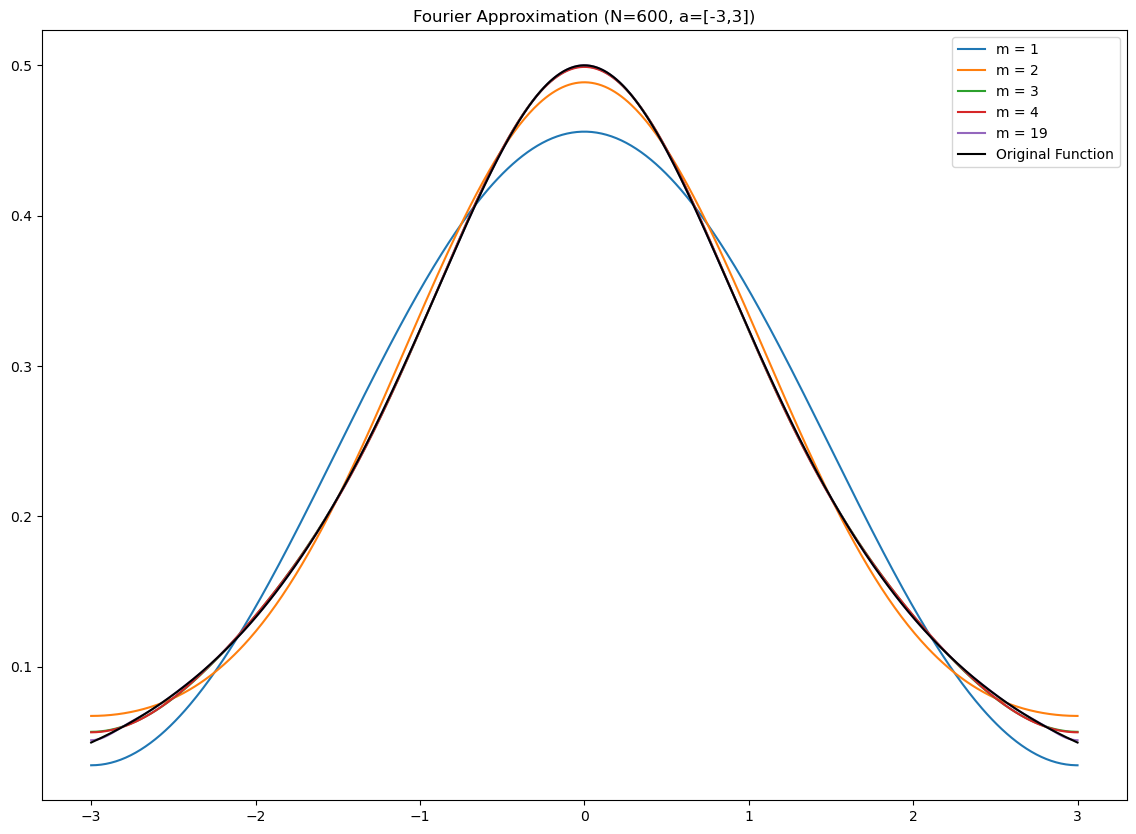

In [9]:
def f1(x):
    return 1 / (np.exp(x) + np.exp(-x))

plot_fourier_approx_and_err(f=f1, a=3, N=600, m_values=list(range(1, 20)))

### (d) - Fehlerberechnung
>Bestimmen Sie die Anzahl der Fourier-Komponenten, die benötigt werden, um eine Approximation mit höchstens $0,1$% relativen Fehler zu erhalten.

> **Note**: Um den relativen Fehler zu berechnen verwenden wir die bereits unter **(c)** notierte $RE$-Metrik.

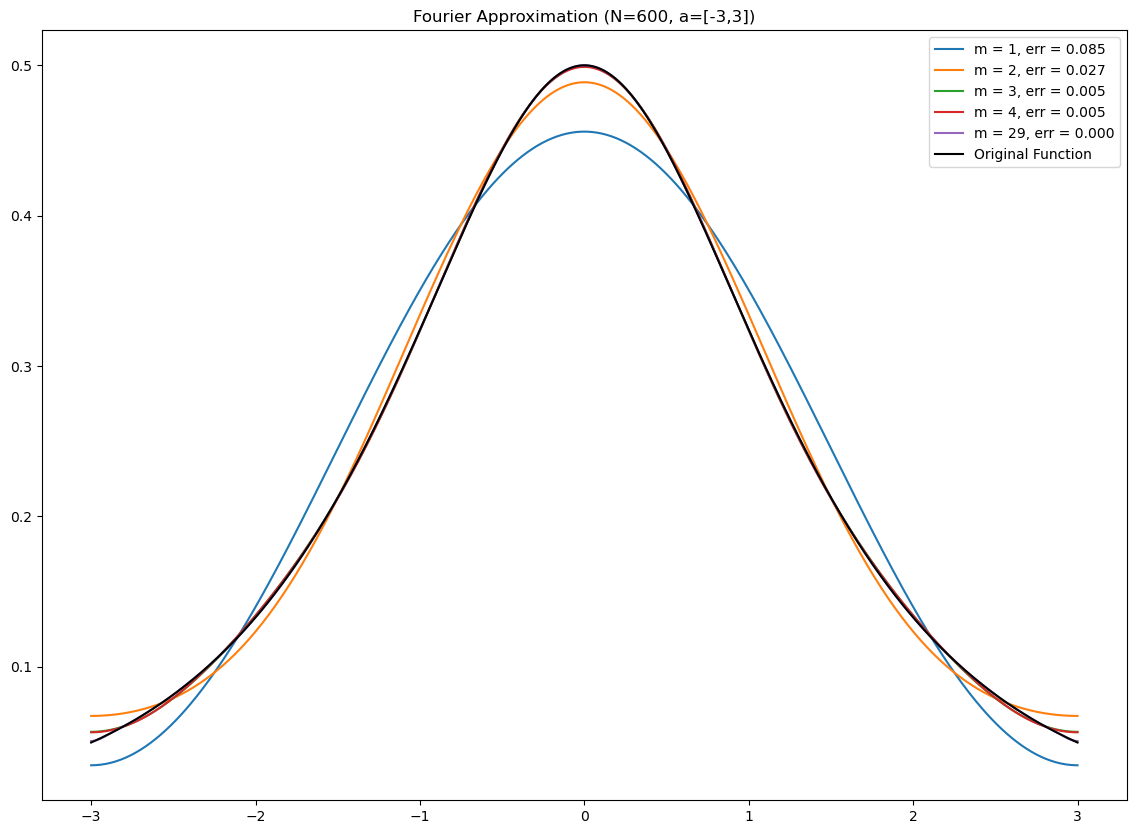

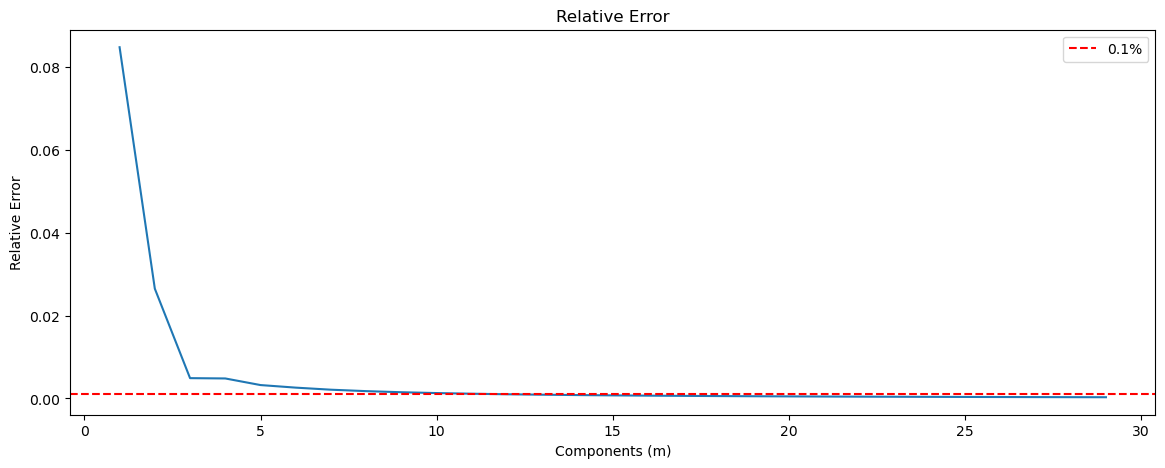

The lowest number of components needed to have an error lower or equal 0.1% is: 13


In [10]:
# Define the interval and number of steps
a = 3
N = 600

# Define the range of m_values to check (1 to 19)
m_values = list(range(1, 30))

# Plot the Fourier approximations and calculate relative errors
errors = plot_fourier_approx_and_err(f=f1, a=a, N=N, m_values=m_values, calc_error=True, err_thresh=0.001)

Für $f_1(x)$ gilt, dass der relative Fehler bei Komponente $13$ einen Wert unter $0.1\%$ annimmt.

Dies ist die hyperbolische Kosinusfunktion ($cosh(x)$), die eine gerade Funktion und symmetrisch zur $y$-Achse ist. Aus den Plots geht hervor, dass die Fourier-Reihe nur Kosinusterm beiträgt, da die Sinusterm aufgrund der Symmetrie verschwinden. Wie erwartet, ist die Konvergenz der Fourier-Reihe schnell und die Approximation sehr genau, was durch die hohe Übereinstimmung von Originalfunktion und Approximation in den Plots ersichtlich ist. Die Glätte der ursprünglichen Funktion fördert eine präzise Approximation.

### (e) - Approximation weiterer Funktionen
> Versuchen Sie die Funktionen $f_2(x) = e^x$ und $f_3(x) = e^{abs(x)}$ auf dem Intervall ($[-3, 3]$) (Auflösung: ($N = 600$ Schritte) mit einem $0,1$%igen Approximationsfehler anzunähern. Beschreiben und erklären Sie die Unterschiede.


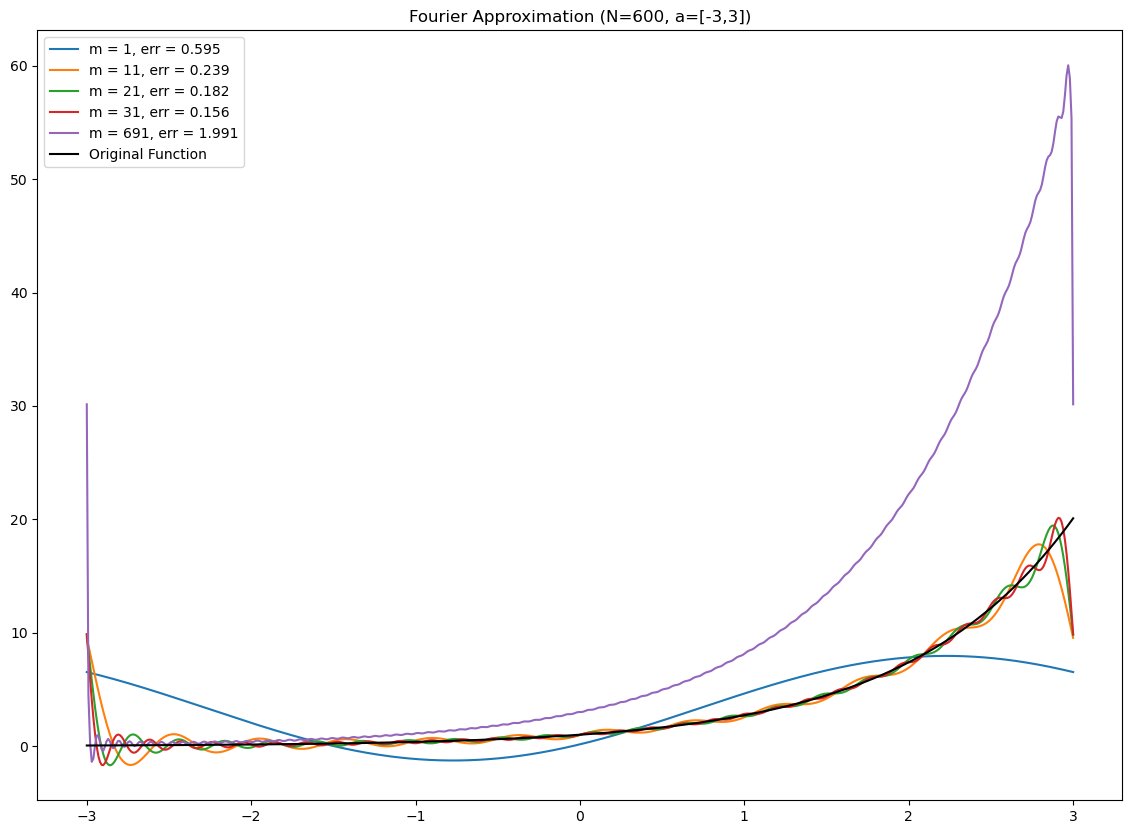

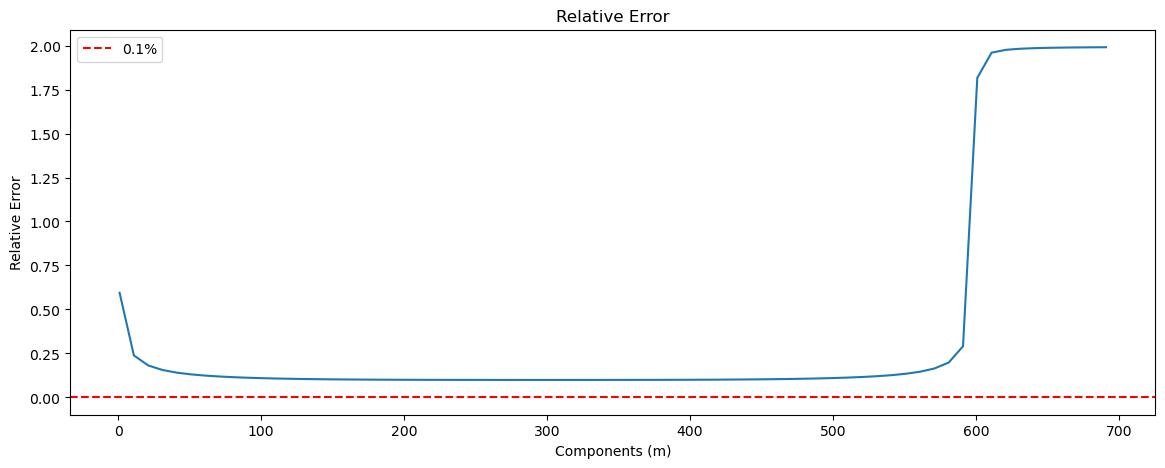

No components yield an error lower or equal to 0.1%.


In [11]:
def f2(x):
    """
    Compute the value of f2(x) = exp(x).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return np.exp(x)

# Define the interval and number of steps
a = 3
N = 600

# Define the range of m_values to check (1 to 19)
m_values = list(range(1, 700, 10))

# Plot the Fourier approximations and calculate relative errors
errors = plot_fourier_approx_and_err(f=f2, a=a, N=N, m_values=m_values, calc_error=True, err_thresh=0.001)

Der Fehler scheint bei $800$ Komponenten **nie** einen Fehler unter $0.1\%$ zu erreichen.

Diese Funktion ist weder gerade noch ungerade, und sie ist exponentiell wachsend. Da die Funktion auf dem Intervall $[-3,3]$ nicht periodisch ist, treten Randeffekte (`Gibbs-Phänomen`) auf, insbesondere an den Rändern des Intervalls, wo die Funktion ansteigt. Diese Funktion benötigt mehr Fourier-Terme benötigen, um innerhalb des gegebenen Fehlers zu bleiben, insbesondere aufgrund des exponentiellen Anstiegs.

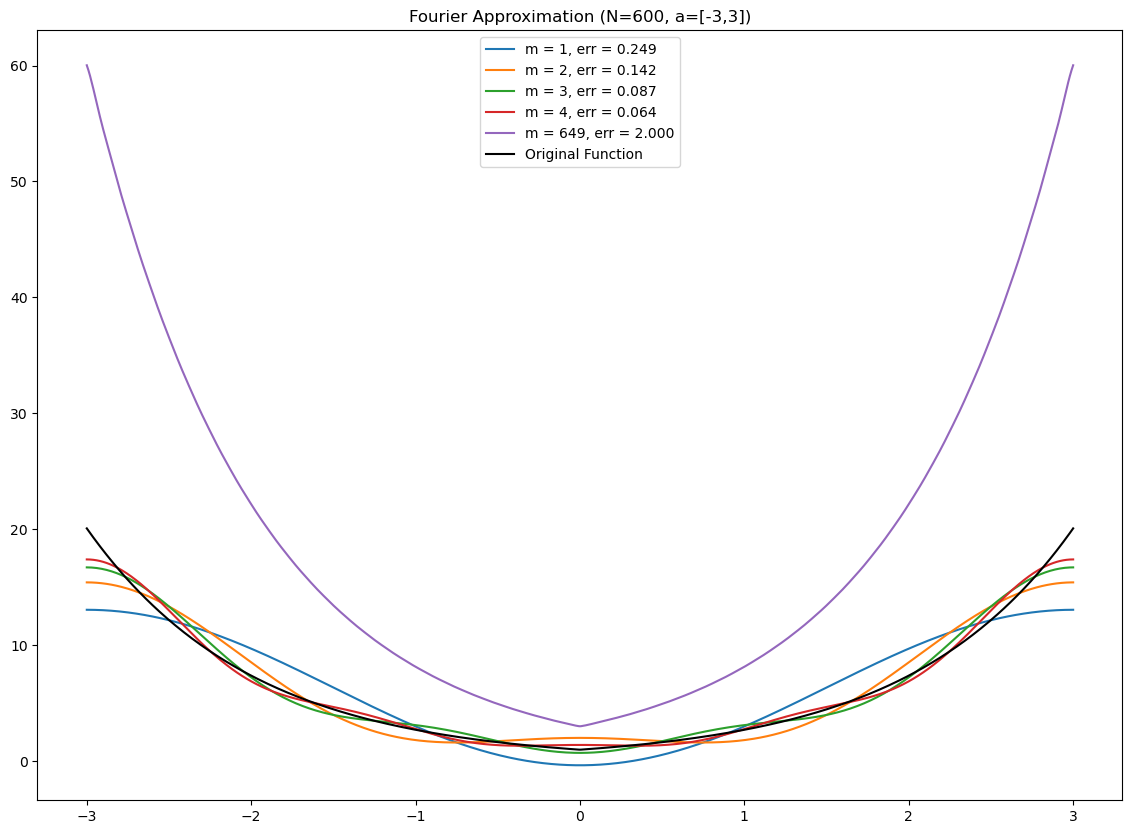

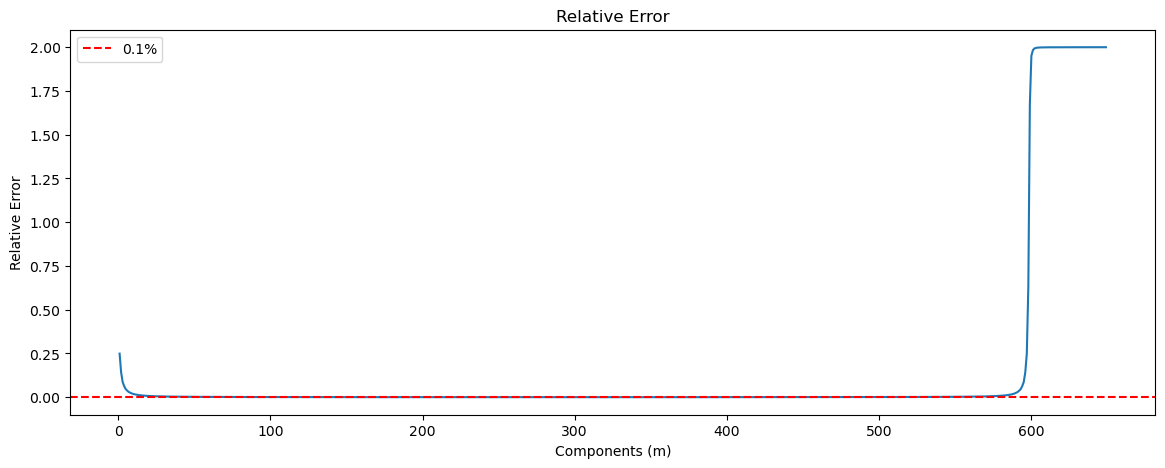

The lowest number of components needed to have an error lower or equal 0.1% is: 93


In [12]:
def f3(x):
    """
    Compute the value of f3(x) = exp(|x|).

    Args:
        x (float or numpy.array): Input value(s) for the function.

    Returns:
        float or numpy.array: Result of the function evaluation at x.
    """
    return np.exp(np.abs(x))

# Define the interval and number of steps
a = 3
N = 600

# Define the range of m_values to check (1 to 799 in steps of 10)
m_values = list(range(1, 650))

# Plot the Fourier approximations and calculate relative errors
errors = plot_fourier_approx_and_err(f=f3, a=a, N=N, m_values=m_values, calc_error=True)

Wir können beobachten, dass der relative Fehler von $1$ bis $800$ Komponenten bei einer Auflösung von $N=600$ den tiefsten Fehler bei $93$ Komponenten annimmt. 

Ebenso wie $f2(x)$ ist diese Funktion nicht periodisch. Ein spezifisches Intervall wurde für die Fourier-Reihe ausgewählt. Es ist jedoch zu beachten, dass die Funktion $abs(x)$ eine Unstetigkeitsstelle bei $x=0$ erzeugt, was in den Plots durch die Diskontinuität bei $x=0$ offensichtlich wird. Dies führt dazu, dass die Konvergenz der Fourier-Reihe an dieser Stelle schwierig wird und das sogenannte `Gibbs-Phänomen` wieder auftritt. Dies ist in den Plots durch den plötzlichen Anstieg der Fourier-Approximation bei $x=0$ zu sehen.

#### Gibbs-Phänomen
Mit Hilfe von Fourier-Reihen lässt sich jede periodische Funktion als Summe von Sinus- und Kosinuswellen darstellen. Wenn wir jedoch versuchen, die Funktion mit einer endlichen Anzahl dieser Wellen zu approximieren, können wir in der Nähe von scharfen Kanten oder Ecken in der ursprünglichen Funktion einige zusätzliche Schwingungen sehen. Dies wird als Gibbs-Phänomen bezeichnet und kann zu Fehlern in unserer Näherung führen.

![](https://i.stack.imgur.com/oyNPh.png)

Referenz:
- [Gibbs phenomenon - Wikiwand](https://www.wikiwand.com/en/Gibbs_phenomenon)
- [Confusion regarding Gibbs phenomenon - stackexchange](https://math.stackexchange.com/questions/1780318/confusion-regarding-gibbs-phenomenon)
- [Fourier Series and Gibbs Phenomena [Matlab] - YouTube](https://youtu.be/98VixA3MjAc)

#### Overfitting

Ein Overfitting liegt vor, wenn ein Modell im Verhältnis zu der Menge und dem Rauschpegel der Daten, die es anzupassen versucht, übermässig komplex ist. Im Falle einer Fourier-Reihe kann jeder Term (Sinus- oder Kosinusfunktion) als ein Parameter oder Freiheitsgrad betrachtet werden, den das Modell zur Anpassung an die Daten verwenden kann. 

Wenn die Anzahl dieser Parameter (`m`) kleiner oder gleich der Anzahl der Datenpunkte (`N`) ist, kann jeder Parameter effektiv abgestimmt werden, um einen Aspekt der Daten zu erfassen. Wenn `m` jedoch `N` übersteigt, gibt es mehr Parameter als Datenpunkte. Das bedeutet, dass einige Parameter im Wesentlichen versuchen, auf dieselben Datenpunkte zu passen, was zu einem Overfitting führt.

Ein Overfit kann in diesem Zusammenhang zu starken Schwankungen zwischen den Datenpunkten führen, da die zusätzlichen Parameter es dem Modell ermöglichen, nicht nur die zugrunde liegende Funktion anzupassen, die die Daten erzeugt hat, sondern auch das zufällige Rauschen in den Daten. Mit anderen Worten, das Modell wird zu flexibel und fängt an, zufällige Variationen zu erfassen, die nicht Teil der wahren zugrunde liegenden Funktion sind. Aus diesem Grund steigt der relative Fehler sprunghaft an, wenn `m` grösser als `N` ist.

Im Wesentlichen versucht das Modell zu sehr, sich perfekt an die Daten anzupassen, und verliert dabei seine Fähigkeit, gut zu verallgemeinern, was sich in einem hohen Fehler beim Vergleich der Fourier-Näherung mit der tatsächlichen Funktion niederschlägt.

## Aufgabe 2 - Sonnenflecken

>In dieser Aufgabe wenden Sie die Fourier-Analyse auf Sonnenfleckendaten an (`sunspots.txt`). Sie dürfen dafür die fft routine von `numpy` oder `scipy` verwenden.

In [13]:
def load_sunspot_data(file_path="sunspots.txt"):
    """
    Diese Funktion lädt Sonnenfleckendaten aus einer Datei und gibt die Jahre und Sonnenfleckenzahlen zurück.

    Args:
        file_path (str, optional): Pfad zur Datei mit den Sonnenfleckendaten. Standard ist "./data/sunspots.txt".

    Returns:
        years (numpy.array): Array mit den aufgezeichneten Jahren.
        sunspots (numpy.array): Array mit den entsprechenden Sonnenfleckenzahlen.
    """
    data = np.loadtxt(file_path)
    reshaped_data = data.reshape(315, 2)
    years = reshaped_data[:, 0]
    sunspots = reshaped_data[:, 1]
    return years, sunspots

(315,) (315,)


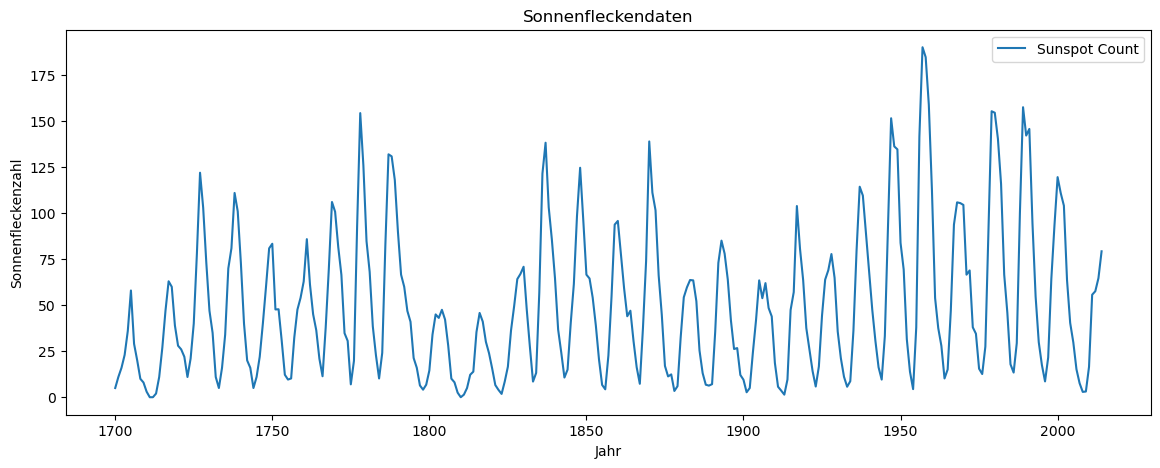

In [14]:
years, sunspots = load_sunspot_data()
print(years.shape, sunspots.shape)

plt.figure()
plt.plot(years, sunspots, label='Sunspot Count')
plt.title("Sonnenfleckendaten")
plt.xlabel("Jahr")
plt.ylabel("Sonnenfleckenzahl")
plt.legend()
plt.show()

In [15]:
# Frequenzberechnung
total_years = years.size
time_step = years[1] - years[0]
sampling_frequency = 1 / time_step

# FFT durchführen
fft_results = fft(sunspots)
frequencies = fftfreq(sunspots.size, d=time_step)

# Positive Frequenzen auswählen
positive_indices = frequencies > 0
positive_frequencies = frequencies[positive_indices]
positive_fft_magnitudes = np.abs(fft_results[positive_indices])

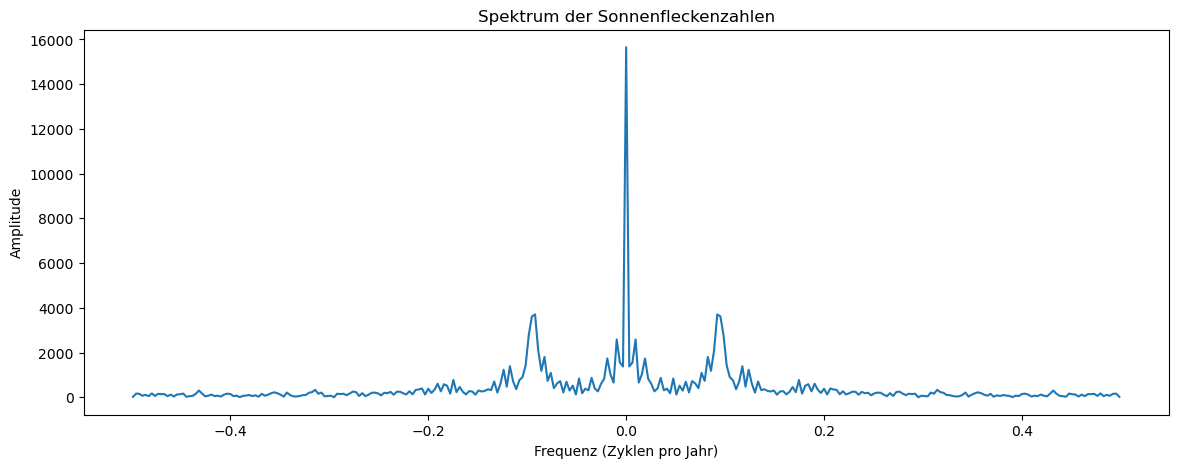

In [16]:
plt.figure()
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_results)))
plt.xlabel("Frequenz (Zyklen pro Jahr)")
plt.ylabel("Amplitude")
plt.title("Spektrum der Sonnenfleckenzahlen")
plt.show()

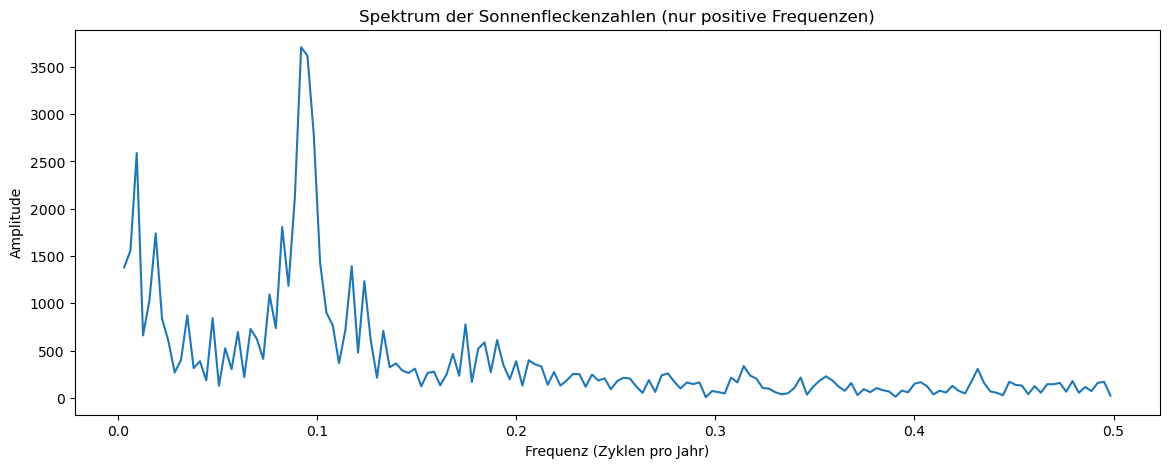

In [17]:
plt.figure()
plt.plot(positive_frequencies, positive_fft_magnitudes)
plt.xlabel("Frequenz (Zyklen pro Jahr)")
plt.ylabel("Amplitude")
plt.title("Spektrum der Sonnenfleckenzahlen (nur positive Frequenzen)")
plt.show()

### (a) - Power Spektrum & dominante Periodizität
>Plotten Sie das Power-Spektrum und finden Sie die dominante Periodizität der Schwingung. Damit erhalten Sie eine Abschätzung auf die Dauer des Sonnenzyklus.

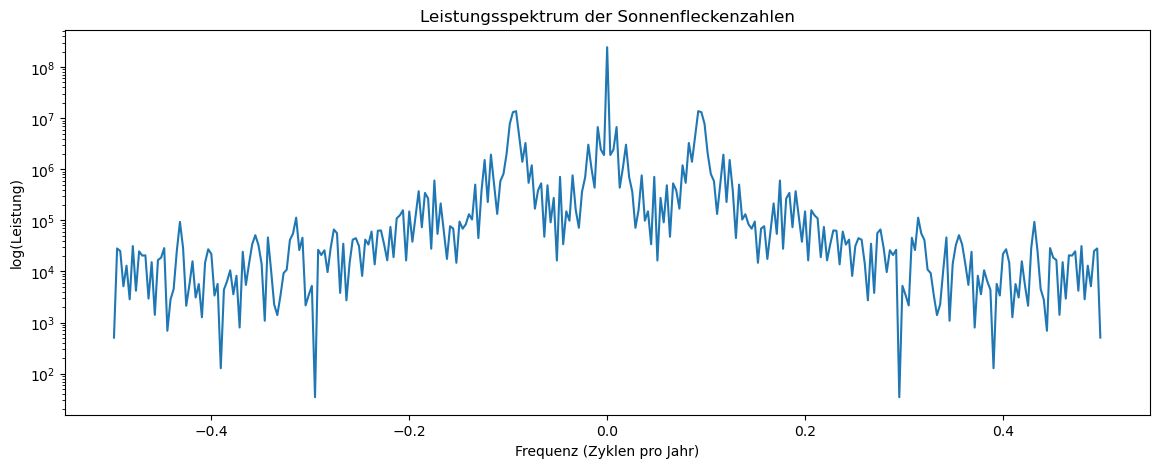

In [18]:
# Plotten des Leistungsspektrums mit logarithmischer Skala
plt.figure()
plt.plot(fftshift(frequencies), np.square(np.abs(fftshift(fft_results))))
plt.xlabel("Frequenz (Zyklen pro Jahr)")
plt.ylabel("log(Leistung)")
plt.title("Leistungsspektrum der Sonnenfleckenzahlen")
plt.yscale('log')
plt.show()

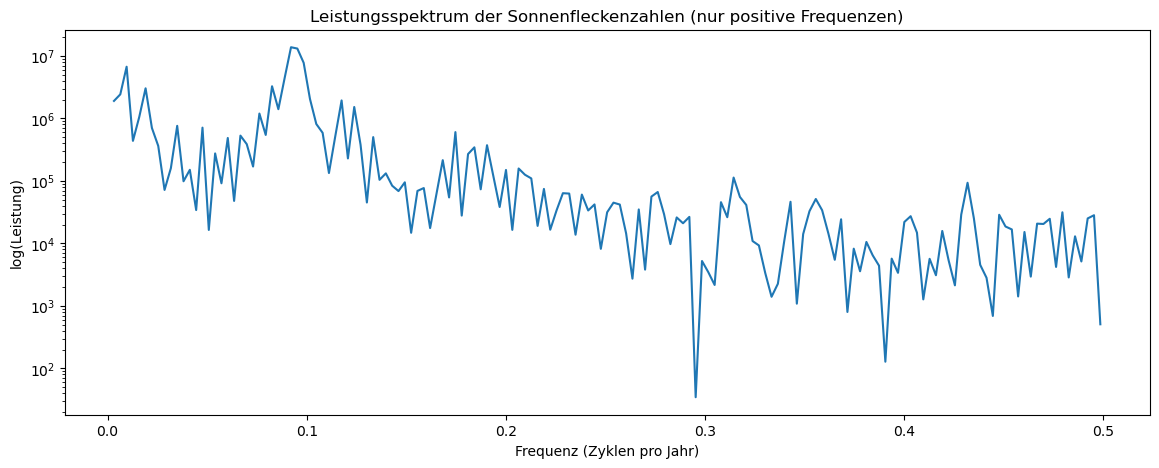

In [19]:
# Plotten des Leistungsspektrums der positiven Frequenzen mit logarithmischer Skala
plt.figure()
plt.plot(positive_frequencies, np.square(np.abs(positive_fft_magnitudes)))
plt.xlabel("Frequenz (Zyklen pro Jahr)")
plt.ylabel("log(Leistung)")
plt.title("Leistungsspektrum der Sonnenfleckenzahlen (nur positive Frequenzen)")
plt.yscale('log')
plt.show()

In [20]:
# Bestimmung der dominanten Frequenz
dominant_frequency = positive_frequencies[np.argmax(np.abs(positive_fft_magnitudes))]
print(f"Dominante Frequenz: {1 / dominant_frequency} Jahre")

Dominante Frequenz: 10.86206896551724 Jahre


### (b) - Weitere Perioden
> Können Sie weitere Perioden in den Sonnenfleck-Daten mithilfe des Fourier-Spektrums finden?

In [21]:
# Schwellenwert für die Höhe der Peaks
höhe_schwellenwert = 1e3

# Berechnung der absoluten Werte der FFT-Ergebnisse
absolute_fft_werte = np.abs(positive_fft_magnitudes)

# Verwendung der find_peaks-Funktion von scipy, um die Indizes der Peaks zu finden
peaks, _ = find_peaks(absolute_fft_werte, height=höhe_schwellenwert)
sortierte_peaks = peaks[np.argsort(absolute_fft_werte[peaks])[::-1]]
sortierte_dominante_frequenzen = positive_frequencies[sortierte_peaks]

# Ausgeben der Frequenzen in absteigender Reihenfolge
print("Dominante Frequenzen im Spektrum (absteigend):")
for index, frequenz in enumerate(sortierte_dominante_frequenzen, start=1):
    print(f"{index}. {1/frequenz:.3f} Jahre")

Dominante Frequenzen im Spektrum (absteigend):
1. 10.862 Jahre
2. 105.000 Jahre
3. 12.115 Jahre
4. 52.500 Jahre
5. 8.514 Jahre
6. 8.077 Jahre
7. 13.125 Jahre


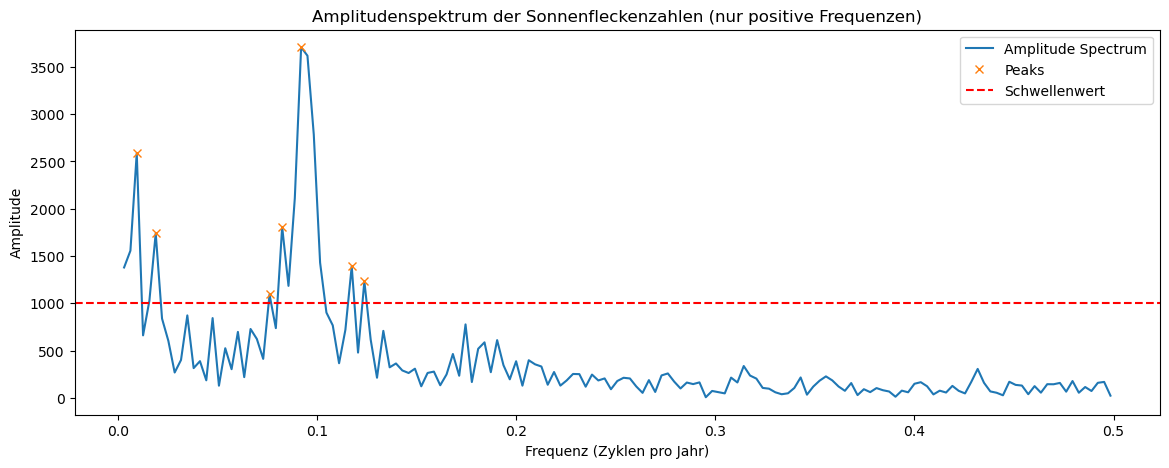

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(positive_frequencies, absolute_fft_werte, label='Amplitude Spectrum')
plt.plot(positive_frequencies[peaks], absolute_fft_werte[peaks], "x", label='Peaks')
plt.axhline(y=höhe_schwellenwert, color='r', linestyle='--', label='Schwellenwert')
plt.xlabel("Frequenz (Zyklen pro Jahr)")
plt.ylabel("Amplitude")
plt.title("Amplitudenspektrum der Sonnenfleckenzahlen (nur positive Frequenzen)")
plt.legend()
plt.show()

Hier sind einige Quellen, die sich mit der Beobachtung der dominierenden Frequenzen der Sonnenflecken beschäftigen:

1. [The ~11-yr Solar Cycle](https://www.semanticscholar.org/paper/The-~-11-yr-Solar-Cycle-Bacon-Organon/04b1dbf40ac1fccc078b33025c33bc81eea62edd) - Dieser Artikel auf Semantic Scholar untersucht den etwa 11-jährigen Sonnenzyklus und seine Auswirkungen auf das Auftreten von Sonnenflecken.

2. [Power spectrum of the sunspot number fluctuation](https://www.researchgate.net/figure/Power-spectrum-of-the-sunspot-number-fluctuation-The-arrow-indicates-the-peak-at-f-11_fig2_2146547) - In dieser Abbildung auf ResearchGate wird das Leistungsspektrum der Schwankungen der Sonnenfleckenzahl dargestellt. Der Pfeil zeigt auf den Peak bei der Frequenz f = 11, der auf den dominanten 11-jährigen Zyklus hinweist.

3. [Dominant frequencies of sunspots](https://www.worldscientific.com/doi/10.1142/S0218348X08004009) - Dieser Artikel auf World Scientific untersucht die dominierenden Frequenzen der Sonnenfleckenaktivität und beschäftigt sich mit ihrer periodischen Natur.

Die ~11 Jahres Frequenz die wir in den Daten beobachten könnenten, scheint also auch schon in anderer Literatur entdeckt worden zu sein.

### (c) - Filtern von Komponenten

>Entfernen Sie einige Komponenten im Fourier-Spektrum und führen dann eine Rücktransformation durch:
>- grössten Komponenten entfernen ($k > 20$)
>- kleinsten Komponenten entfernen ($k < 5$)
>Beschreiben und erklären Sie die Ergebnisse.

In [23]:
# Frequenzen filtern: unter 5 Jahre (k < 5) und 0
filter_unter_5 = (np.abs(frequencies) > 1 / 5) | (frequencies == 0)

# Frequenzen filtern: über 20 Jahre (k > 20)
filter_über_20 = np.abs(frequencies) < 1 / 20

# Anwenden der Filter auf die FFT-Werte
fft_werte_unter_5 = fft_results * filter_unter_5
fft_werte_über_20 = fft_results * filter_über_20

Die Null-Frequenzkomponente einer Fourier-Transformation repräsentiert den Durchschnitt oder die Gleichstromkomponente (DC-Component) des Signals. Mit anderen Worten, es ist der konstante Versatz des Signals von Null.

Für einige Analysen ist die Null-Frequenzkomponente möglicherweise nicht sehr interessant, insbesondere wenn man sich auf die periodischen oder oszillatorischen Aspekte der Daten konzentriert. Für andere Analysen kann sie jedoch entscheidend sein. Wenn man beispielsweise ein Signal mit einem von Null verschiedenen Mittelwert untersucht, repräsentiert die Null-Frequenzkomponente diesen Mittelwert. Wenn man sie entfernt, würde man das Signal effektiv mitteln, was die Interpretation der Ergebnisse beeinflussen könnte.

Wenn also wie in diesem Fall das Signal eine signifikante Gleichstromkomponente hat (Mittelwert signifikant von Null verschieden), zeigt sich dies als Spitze bei der Nullfrequenz. Wenn diese herausgefiltert wird, würde die Charakteristik der Daten ignoriert werden. Die mathematische Intuition hinter dem Nicht-Filtern der Nullfrequenz besteht also darin, den Mittelwert des Signals beizubehalten.

Um diesem Problem vorzubeugen, hätte man die Daten vor der Transformation auch so normalisieren können, dass der Durchschnitt der y-Werte bei null liegt.

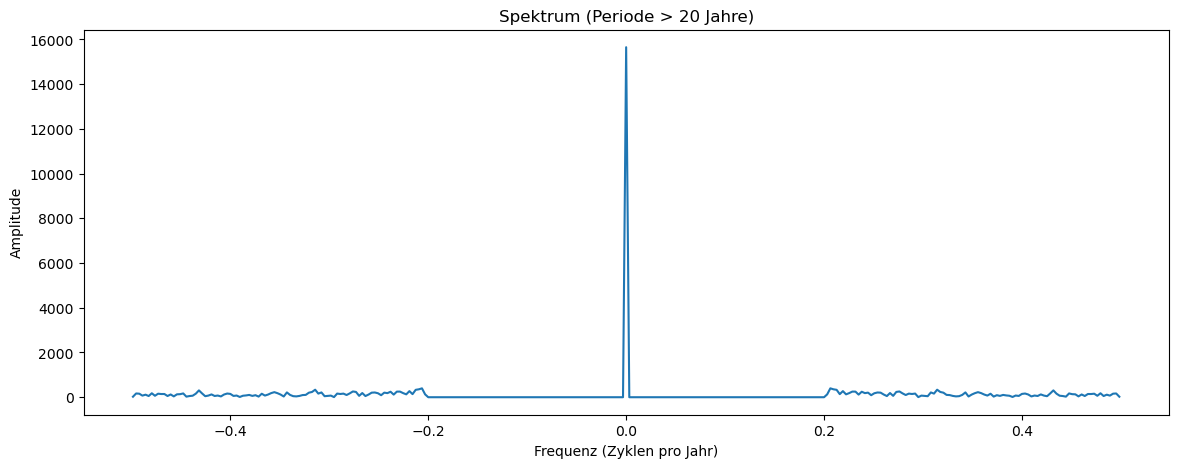

In [24]:
# Plotten des Spektrums für Perioden > 20 Jahre
plt.figure()
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_werte_unter_5)))
plt.xlabel("Frequenz (Zyklen pro Jahr)")
plt.ylabel("Amplitude")
plt.title("Spektrum (Periode > 20 Jahre)")
plt.show()

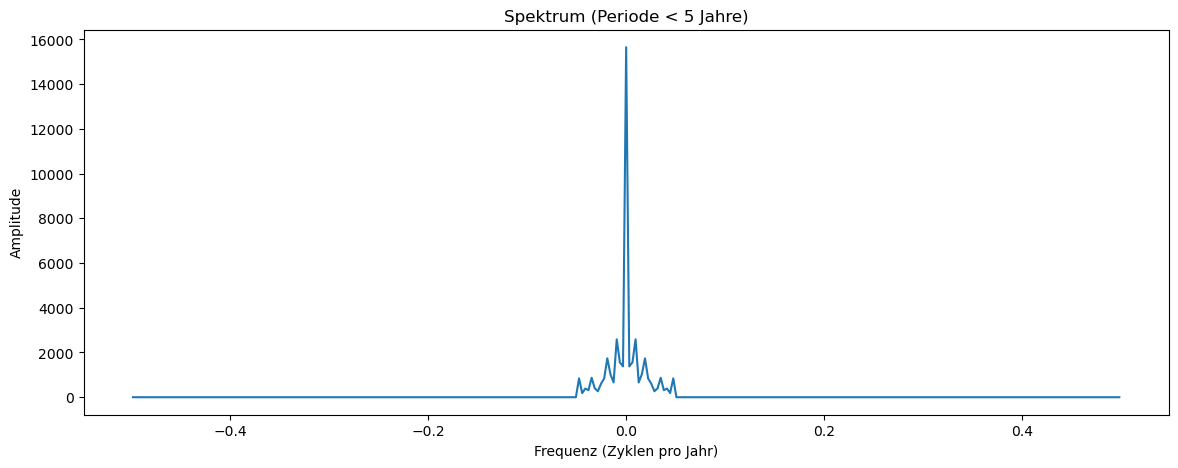

In [25]:
# Plotten des Spektrums für Perioden < 5 Jahre
plt.figure()
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_werte_über_20)))
plt.xlabel("Frequenz (Zyklen pro Jahr)")
plt.ylabel("Amplitude")
plt.title("Spektrum (Periode < 5 Jahre)")
plt.show()

In [26]:
# Zurück in den Zeitbereich durch inverse FFT
gefilterte_sonnenflecken_über_5 = np.fft.ifft(fft_werte_unter_5).real
gefilterte_sonnenflecken_unter_20 = np.fft.ifft(fft_werte_über_20).real

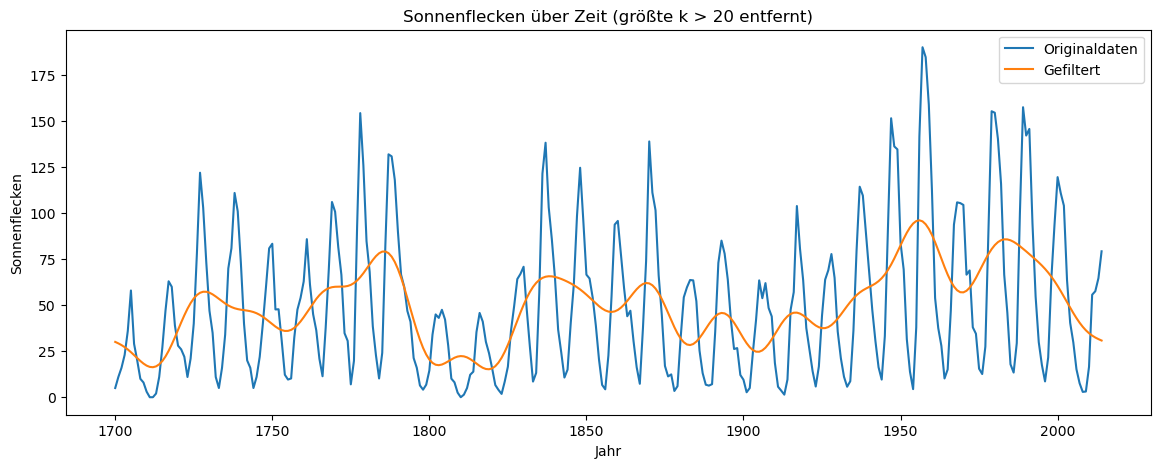

In [27]:
# Plotten der gefilterten Daten im Zeitbereich (größte k > 20 entfernt)
plt.figure()
plt.plot(years, sunspots, label="Originaldaten")
plt.plot(years, gefilterte_sonnenflecken_unter_20, label="Gefiltert")
plt.xlabel("Jahr")
plt.ylabel("Sonnenflecken")
plt.title("Sonnenflecken über Zeit (größte k > 20 entfernt)")
plt.legend()
plt.show()

Wenn die grössten Komponenten ($k > 20$) enfernt werden, werden die schnellen Schwankungen oder "Rauschen" aus den Daten entfernt. Dies führt zu einer Glättung der Daten, da nur die grundlegenden Trends übrig bleiben. Das kann beispielsweise in Anwendungen nützlich sein, in denen Sie an langfristigen Trends interessiert sind und kurzfristige Schwankungen als Störungen betrachten.

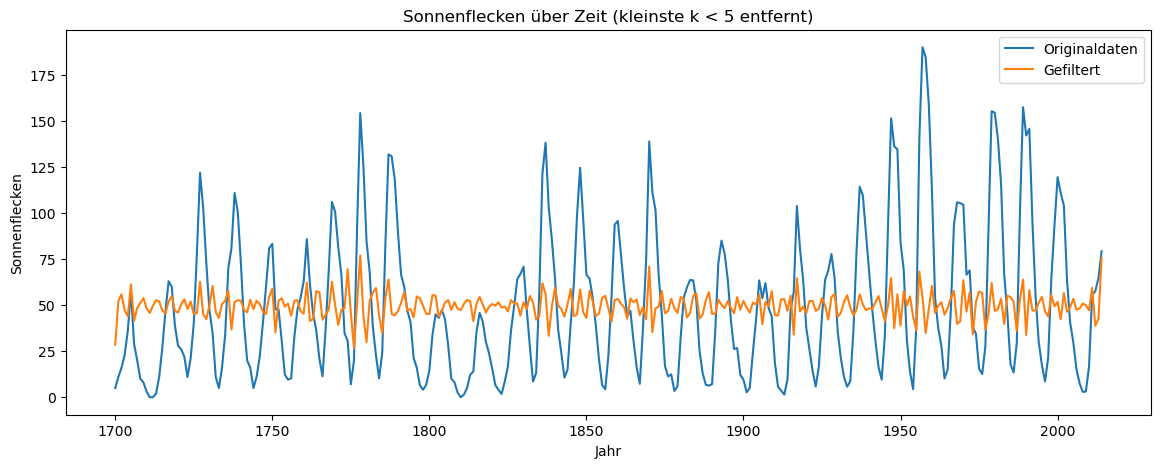

In [28]:
# Plotten der gefilterten Daten im Zeitbereich (kleinste k < 5 entfernt)
plt.figure()
plt.plot(years, sunspots, label="Originaldaten")
plt.plot(years, gefilterte_sonnenflecken_über_5, label="Gefiltert")
plt.xlabel("Jahr")
plt.ylabel("Sonnenflecken")
plt.title("Sonnenflecken über Zeit (kleinste k < 5 entfernt)")
plt.legend()
plt.show()

Wenn die kleinsten Komponenten ($k < 5$) enfernt werden, werden die grundlegenden Trends enfernt und die schnellen Schwankungen behalten. Das Ergebnis sieht sehr rauschhaft aus, da die langsam variierenden Komponenten, die den grundsätzlichen Charakter der Daten ausmachen, fehlen.

### (d) - Unterschiede zu den Fourier-Koeffizienten in Aufgabe 1

> Vergleichen Sie die Ergebnisse mit denen aus Aufgabe 1. Beschreiben und erklären Sie Unterschiede in den Fourier-Koeffizienten.

Wir vergleichen dabei die Koeffizienten der Sonnenflecken Daten zu denen der drei Funktionen aus `Aufgabe 1`. Als Erinnerung:
- $f_1(x) = \frac{1}{{e^x + e^{-x}}}$
- $f_2(x) = e^x$
- $f_3(x) = e^{abs(x)}$

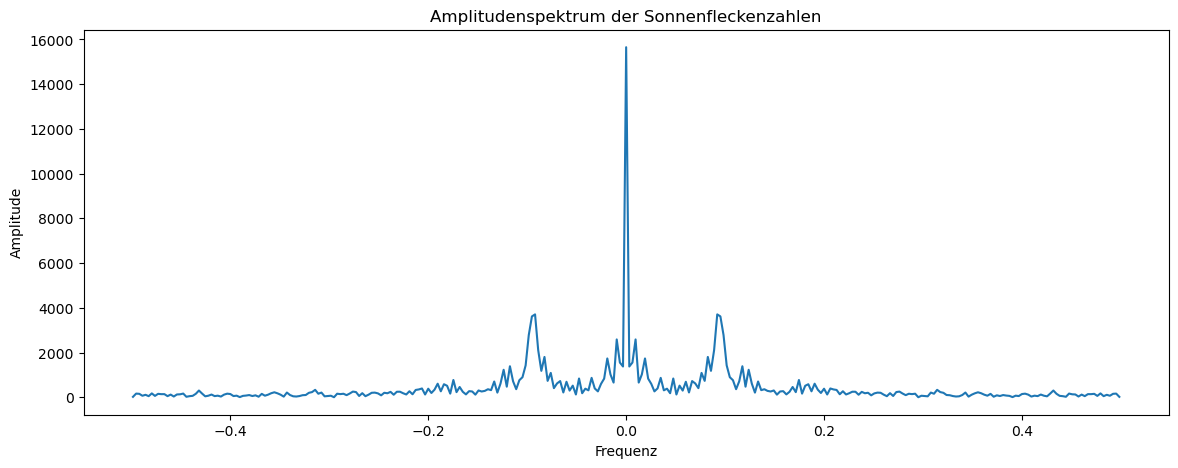

In [29]:
# Plotten der Fourier-Koeffizienten der Sonnenflecken
plt.figure()
plt.plot(fftshift(frequencies), np.abs(fftshift(fft_results)))
plt.title("Amplitudenspektrum der Sonnenfleckenzahlen")
plt.ylabel("Amplitude")
plt.xlabel("Frequenz")
plt.show()

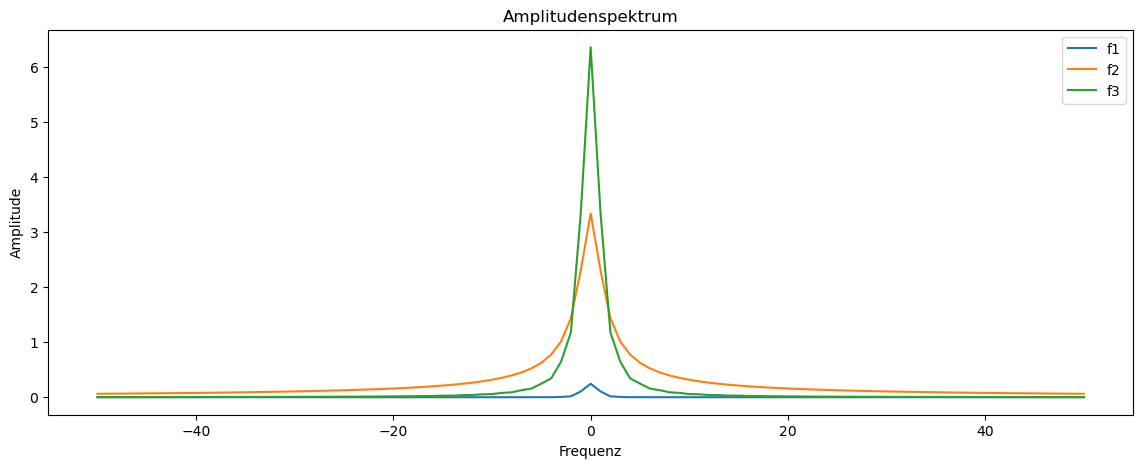

In [30]:
# Liste der Funktionen für die Fourier-Approximation
funktionen_aufgabe1 = [f1, f2, f3]
for index, funktion in enumerate(funktionen_aufgabe1):
    _, _, _, koeffizienten = fourier_approximation(f=funktion, a=3, N=600, m=50)
    plt.plot(np.arange(-50, 51), np.abs(koeffizienten), label=f"f{index+1}")

# Plotten des Amplitudenspektrums
plt.title("Amplitudenspektrum")
plt.xlabel("Frequenz")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

Es ist wichtig zu beachten, dass der Vergleich der Fourier-Koeffizienten von zwei unterschiedlichen Funktionen oder Datensätzen (in diesem Fall Sonnenfleckendaten und den Funktionen aus `Aufgabe 1`) nicht unbedingt sinnvolle Einblicke liefert, da die Koeffizienten spezifisch für die jeweilige Funktion oder die Daten sind. Sie repräsentieren die Stärke der verschiedenen periodischen Komponenten in den Daten oder der Funktion.

Dennoch können wir einige allgemeine Überlegungen anstellen:
- Die Fourier-Koeffizienten der Sonnenfleckendaten werden zeigen mehrere dominante Frequenzen, die unter andrem den bekannten Sonnenzyklen entsprechen. Diese erscheinen als Spitzen im Frequenzspektrum (oder als hohe Werte in den Koeffizienten).

- Für die Funktionen aus `Aufgabe 1` gibt die Fourier-Reihe (abhängig von der Periode der Funktion, die approximiert wird) typischerweise eine abnehmende Amplitude der Koeffizienten mit zunehmender Frequenz, da höhere Frequenzen immer weniger zur Gesamtform der Funktion beitragen.

- In Bezug auf die Werte der Koeffizienten selbst: Da die Sonnenfleckendaten und die Funktionen aus `Aufgabe 1` auf einer unterschiedlicher Skala / Einheit sind, sind die absoluten Werte der Koeffizienten sehr unterschiedlich.

## Aufgabe 3 - Musikbearbeitung
>In dieser Aufgabe analysieren und bearbeiten Sie ein Musikstück (`music.wav`). Sie dürfen dafür zB die fft routine von `numpy` oder `scipy` sowie das `librosa` und `soundfile` paket verwenden.

In [31]:
# Laden der Musikdatei
audio_data, sample_rate = librosa.load("music.wav")

# Audio abspielen
Audio(audio_data, rate=sample_rate)

### (a) - Wellenform des Klangs 
> Plotten Sie die Wellenform des Klangs (waveplot) - einmal vollständig und einmal für einen kleinen Zeitberech, sodass die Wellenform deutlich wird - sowie das Amplitudenspektrum. Wieso ist das Amplitudenspektrum symmetrisch bezüglich des Vorzeichens?

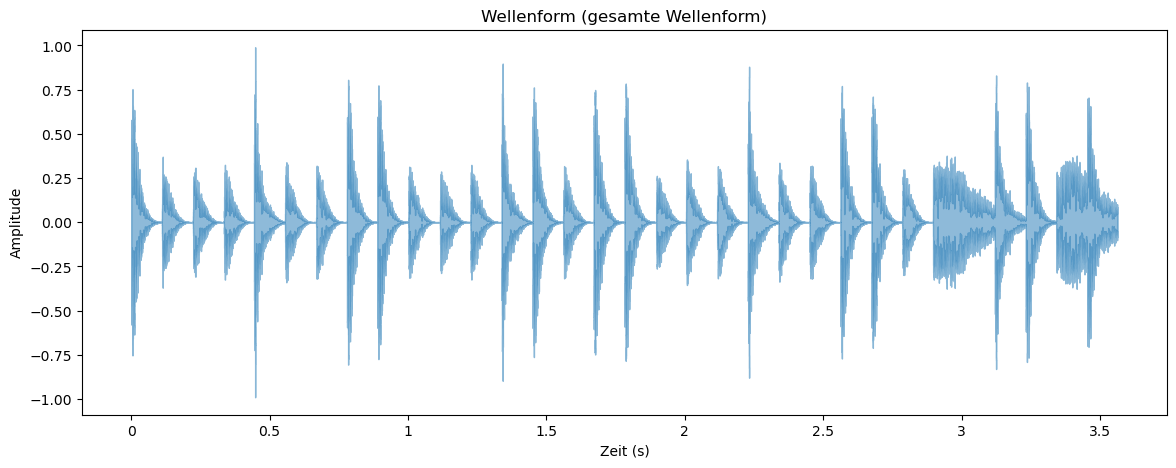

In [32]:
# Anzeige der Wellenform der Musikdatei
librosa.display.waveshow(audio_data, sr=sample_rate, alpha=0.5)
plt.title("Wellenform (gesamte Wellenform)")
plt.ylabel("Amplitude")
plt.xlabel("Zeit (s)")
plt.show()

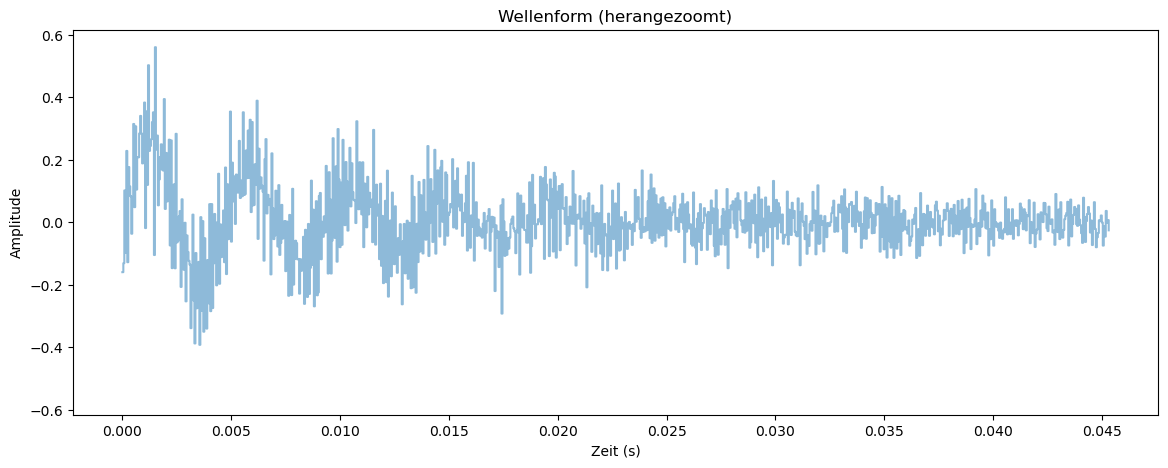

In [33]:
# Anzeige der gezoomten Wellenform der Musikdatei
librosa.display.waveshow(audio_data[10000:11000], sr=sample_rate, alpha=0.5)
plt.title("Wellenform (herangezoomt)")
plt.ylabel("Amplitude")
plt.xlabel("Zeit (s)")
plt.show()

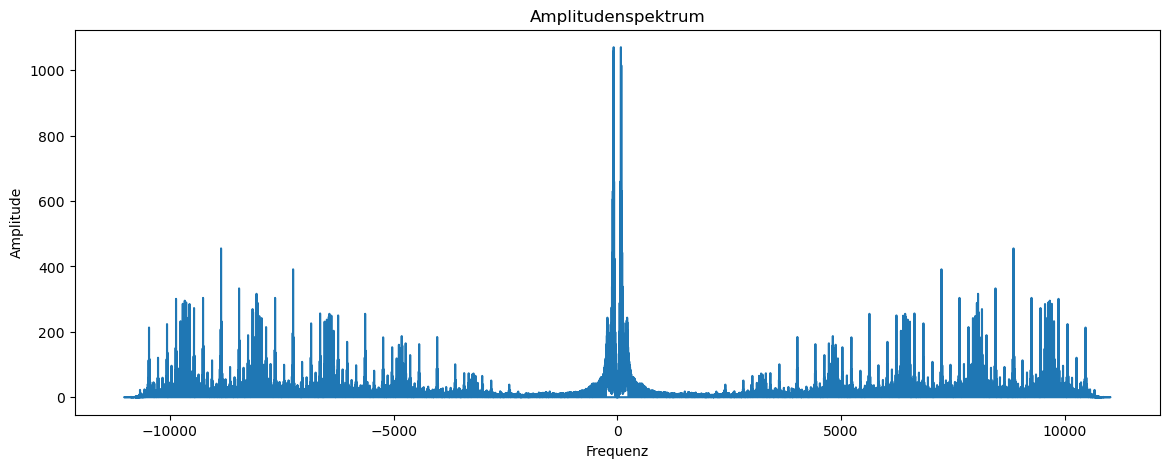

In [34]:
# Berechnung der FFT und Frequenzen
fft_ergebnis = fft(audio_data)
frequenzen = fftfreq(len(audio_data), 1 / sample_rate)

# Plotten des Amplitudenspektrums
plt.figure()
plt.plot(frequenzen, np.abs(fft_ergebnis))
plt.title("Amplitudenspektrum")
plt.ylabel("Amplitude")
plt.xlabel("Frequenz")
plt.show()

#### Warum ist das Amplitudenspektrum symmetrisch bezüglich des Vorzeichens?

Das Amplitudenspektrum ist symmetrisch bezüglich des Vorzeichens, weil die Fouriertransformation, die zur Berechnung des Amplitudenspektrums verwendet wird, reellwertige Funktionen in komplexe Funktionen umwandelt. Bei reellwertigen Funktionen ist der Realteil des Amplitudenspektrums gerade und der Imaginärteil ungerade. Das bedeutet, dass die Amplituden der positiven und negativen Frequenzkomponenten gleich sind, während die Phasen der negativen Frequenzkomponenten das negative Vorzeichen der Phasen der positiven Frequenzkomponenten haben.

Die Symmetrie des Amplitudenspektrums ist eine direkte Folge der Symmetrie der Fouriertransformation. Die Fouriertransformation einer reellwertigen Funktion $f(t)$ ist gegeben durch:

$$
F(\omega)=\int_{-\infty}^{\infty} f(t) e^{-i \omega t} d t
$$

Da $f(t)$ reellwertig ist, gilt:

$$
F(-\omega)=\int_{-\infty}^{\infty} f(t) e^{i \omega t} d t=F^*(\omega)
$$

Das bedeutet, dass das Amplitudenspektrum, das den Betrag der Fouriertransformierten darstellt, symmetrisch bezüglich des Vorzeichens ist:

$$
|F(-\omega)|=|F(\omega)|
$$

Source:

- [tuwien](https://ti.tuwien.ac.at/cps/teaching/courses/dspv/files/DFT-FFT.pdf)


### (b) - High- und Low-Pass Filter
>Trennen Sie den Sound-Signal in einen Teil oberhalb und unterhalb von $2$kHz in Frequenzen. Identifizieren Sie jeweils die Top 5 Frequenzen in diesen Frequenzbereichen.

In [35]:
# Erstellung von Masken für Frequenzen unter und über 2 kHz
maske_unter_2kHz = np.abs(frequenzen) < 2000
maske_über_2kHz = np.abs(frequenzen) > 2000

# Anwendung der Masken auf die FFT-Ergebnisse
fft_unter_2kHz = fft_ergebnis * maske_unter_2kHz
fft_über_2kHz = fft_ergebnis * maske_über_2kHz

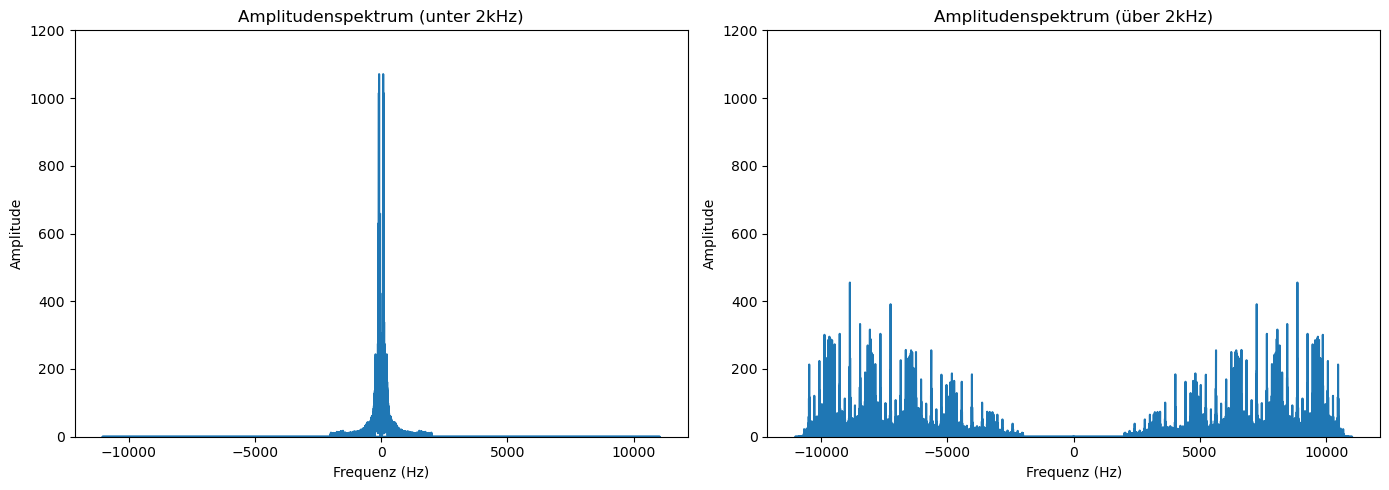

In [36]:
# Erstellen der Subplots für die Amplitudenspektren unter und über 2 kHz
fig, (ax_unter, ax_über) = plt.subplots(1, 2)

# Plotten des Amplitudenspektrums unter 2 kHz
ax_unter.plot(frequenzen, np.abs(fft_unter_2kHz))
ax_unter.set_title("Amplitudenspektrum (unter 2kHz)")
ax_unter.set_xlabel("Frequenz (Hz)")
ax_unter.set_ylabel("Amplitude")
ax_unter.set_ylim([0, 1200])

# Plotten des Amplitudenspektrums über 2 kHz
ax_über.plot(frequenzen, np.abs(fft_über_2kHz))
ax_über.set_title("Amplitudenspektrum (über 2kHz)")
ax_über.set_xlabel("Frequenz (Hz)")
ax_über.set_ylabel("Amplitude")
ax_über.set_ylim([0, 1200])

plt.tight_layout()
plt.show()

In [37]:
# Maske für positive Frequenzen erstellen
positive_frequenzen_maske = frequenzen >= 0

# Negative Frequenzen herausfiltern
fft_unter_2kHz_positiv = fft_unter_2kHz[positive_frequenzen_maske]
fft_über_2kHz_positiv = fft_über_2kHz[positive_frequenzen_maske]

frequenzen_positiv = frequenzen[positive_frequenzen_maske]

# Identifizieren der Top 5 Frequenzen in diesen Frequenzbereichen
top_5_frequenzen_unter_2kHz = np.argsort(np.abs(fft_unter_2kHz_positiv))[-5:]
top_5_frequenzen_über_2kHz = np.argsort(np.abs(fft_über_2kHz_positiv))[-5:]

In [38]:
def ausgabe_top_frequenzen(frequenzen):
    """
    Gibt die höchsten Frequenzen in einer gegebenen Liste aus.

    Args:
        frequenzen (list oder numpy.array): Liste der Frequenzen in Hz.

    Returns:
        None
    """
    for frequenz in sorted(frequenzen):
        print(f"- {frequenz:.3f} Hz")

print("Top 5 Frequenzen unter 2kHz:")
ausgabe_top_frequenzen(frequenzen_positiv[top_5_frequenzen_unter_2kHz])

print()
print("Top 5 Frequenzen über 2kHz:")
ausgabe_top_frequenzen(frequenzen_positiv[top_5_frequenzen_über_2kHz])

Top 5 Frequenzen unter 2kHz:
- 71.829 Hz
- 80.807 Hz
- 81.930 Hz
- 89.786 Hz
- 90.908 Hz

Top 5 Frequenzen über 2kHz:
- 7246.840 Hz
- 8064.733 Hz
- 8454.740 Hz
- 8857.373 Hz
- 9260.007 Hz


### (c) - Fehlerberechnung der Rekonstruktion
> Berechnen Sie aus diesen beiden Teilen jeweils eine Rekonstruktion. Berechnen Sie den Fehler der Rekonstruktion wie in `Aufgabe 1` für die gefilterten Signale und schreiben Sie die gefilterten rekonstruierten Daten in eine `wav`-Datei. Beschreiben und erklären Sie das Ergebnis.

In [39]:
def plot_signale(original_signal, rekonstruierte_signal, plot_title):
    """
    Plotte die Original- und rekonstruierten Signale.

    Args:
        original_signal (numpy.array): Das Originalsignal.
        rekonstruierte_signal (numpy.array): Das rekonstruierte Signal.
        plot_title (str): Der Titel des Plots.

    Returns:
        None
    """
    plt.figure()
    plt.plot(original_signal, label="Originalsignal")
    plt.plot(rekonstruierte_signal, label="Rekonstruierte Signal")
    plt.title(plot_title)
    plt.xlabel("Zeit")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

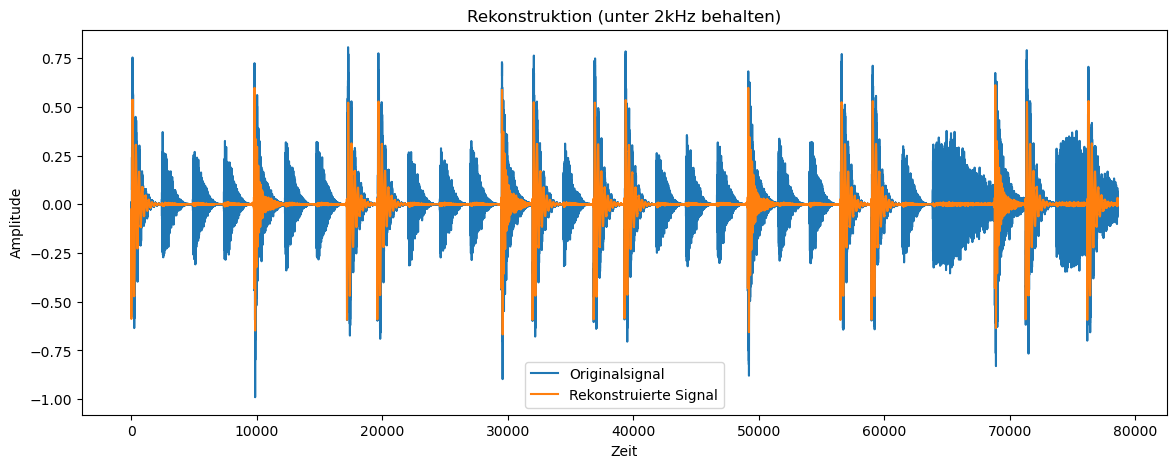

In [40]:
# Inverse FFT durchführen, um das rekonstruierte Signal unter 2 kHz zu erhalten
rekonstruiert_unter_2kHz = np.fft.ifft(fft_unter_2kHz).real

# Plotten der Original- und rekonstruierten Signale
plot_signale(audio_data, rekonstruiert_unter_2kHz, "Rekonstruktion (unter 2kHz behalten)")

# Abspielen des rekonstruierten Signals
Audio(data=rekonstruiert_unter_2kHz, rate=sample_rate)

Das Audio, bei welchem die Frequenzen unter $2$kHz behalten wurden, ist beim anhören eher tief. Das ergibt auch Sinn, da hohe Frequenzen aus dem Signal entfernt wurden. Dies ist auch deutlich im Plot zu erkennen.

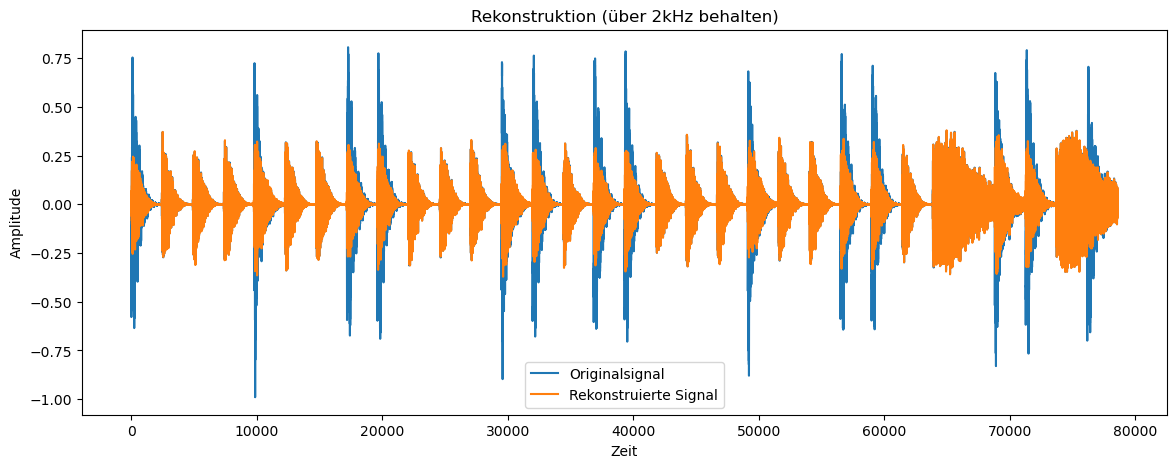

In [41]:
# Inverse FFT durchführen, um das rekonstruierte Signal über 2 kHz zu erhalten
rekonstruiert_über_2kHz = np.fft.ifft(fft_über_2kHz).real

# Plotten der Original- und rekonstruierten Signale
plot_signale(original_signal=audio_data, rekonstruierte_signal=rekonstruiert_über_2kHz, plot_title="Rekonstruktion (über 2kHz behalten)")

# Abspielen des rekonstruierten Signals
Audio(data=rekonstruiert_über_2kHz, rate=sample_rate)

In [42]:
# Fehler der Rekonstruktion unter 2kHz berechnen und ausgeben
fehler_unter_2kHz = rel_error(audio_data, rekonstruiert_unter_2kHz) * 100
print(f"Rekonstruktionsfehler (unter 2kHz behalten): {fehler_unter_2kHz:.3f} %")

# Fehler der Rekonstruktion über 2kHz berechnen und ausgeben
fehler_über_2kHz = rel_error(audio_data, rekonstruiert_über_2kHz) * 100
print(f"Rekonstruktionsfehler (über 2kHz behalten): {fehler_über_2kHz:.3f} %")

Rekonstruktionsfehler (unter 2kHz behalten): 57.833 %
Rekonstruktionsfehler (über 2kHz behalten): 81.581 %


In [43]:
# Speichern der rekonstruierten Audiodaten in WAV-Dateien
sf.write("rekonstruiert_unter_2kHz.wav", rekonstruiert_unter_2kHz, sample_rate)
sf.write("rekonstruiert_über_2kHz.wav", rekonstruiert_über_2kHz, sample_rate)

## Aufgabe 4 - Bildbearbeitung
>In dieser Aufgabe analysieren und bearbeiten Sie eine Bilddatei (`img.jpg`). Sie dürfen dafür die fft routine von `numpy` oder `scipy` verwenden.

In [44]:
# Plotting functions

def plot_image(img, title, cmap="viridis"):
    """
    Plots an image.

    Args:
        img (numpy.array): The image to plot.
        title (str): The title for the plot.
        cmap (str, optional): The colormap to use. Defaults to "viridis".
    """
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()


def plot_spectrum(spectrum, title):
    """
    Plots the Fourier spectrum of an image.

    Args:
        spectrum (numpy.array): The Fourier spectrum to plot.
        title (str): The title for the plot.
    """
    # Take log of spectrum for better visual representation
    # https://www.perplexity.ai/search/7bae3a4c-96d4-4061-9833-289be445fd02?s=c
    plt.imshow(np.log1p(np.abs(spectrum)), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2))
    plt.title(title)
    plt.colorbar()
    plt.show()


def plot_image_and_spectrum(img, spectrum, title):
    """
    Plots an image and its Fourier spectrum side by side.

    Args:
        img (numpy.array): The image to plot.
        spectrum (numpy.array): The Fourier spectrum to plot.
        title (str): The title for the plot.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(img, cmap="gray")
    ax1.set_title("Reconstructed Image")

    # Take logarithm like above or change coloring range to make differences stand out
    #ax2.imshow(np.abs(spectrum), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2), vmin=0, vmax=6)
    spectrum_image = ax2.imshow(np.log1p(np.abs(spectrum)), cmap='viridis', extent=(-img.shape[1] // 2, img.shape[1] // 2, -img.shape[0] // 2, img.shape[0] // 2))
    
    fig.colorbar(spectrum_image, ax=ax2, orientation='vertical')
    ax2.set_title("Spectrum")

    plt.suptitle(title)
    plt.show()

In [45]:
## Filtering functions

def filter_spectrum(spectrum, threshold):
    """
    Filters a Fourier spectrum by a threshold.

    Args:
        spectrum (numpy.array): The Fourier spectrum to filter.
        threshold (float): The threshold value.

    Returns:
        numpy.array: The filtered Fourier spectrum.
    """
    return spectrum * (np.abs(spectrum) > threshold)


def calculate_compression_rate(original_spectrum, compressed_spectrum):
    """
    Calculates the compression rate of the data.

    Args:
        original_spectrum (numpy.array): The original Fourier spectrum.
        compressed_spectrum (numpy.array): The filtered (compressed) Fourier spectrum.

    Returns:
        float: The compression rate.
    """
    return 1 - (np.sum(np.abs(compressed_spectrum)) / np.sum(np.abs(original_spectrum)))


def compress_and_reconstruct(img, threshold_percent):
    """
    Compresses an image by filtering its Fourier spectrum and then reconstructs the image.

    Args:
        img (numpy.array): The image to compress and reconstruct.
        threshold_percent (float): The threshold as a percentage of the maximum value in the Fourier spectrum.

    Returns:
        tuple: A tuple containing:
            - img_reconstructed (numpy.array): The reconstructed image.
            - filtered_spectrum (numpy.array): The filtered Fourier spectrum.
            - error (float): The relative error between the original and reconstructed image.
            - data_kept_percentage (float): The percentage of data kept after filtering.
    """
    spectrum = fft2(img)
    spectrum_shifted = fftshift(spectrum)

    # Filtering
    threshold = threshold_percent * np.max(np.abs(spectrum_shifted))
    filtered_spectrum = filter_spectrum(spectrum_shifted, threshold)

    # Compression rate
    compression_rate = calculate_compression_rate(spectrum_shifted, filtered_spectrum)

    # Inverse
    filtered_spectrum_unshifted = ifftshift(filtered_spectrum)
    img_reconstructed = ifft2(filtered_spectrum_unshifted).real

    return img_reconstructed, filtered_spectrum, rel_error(img, img_reconstructed), compression_rate

#### Berechnung des Kompressionsrate
Wir verwenden einen besonderen Ansatz zur Berechnung der Kompressionsrate bei der Bildkompression. In diesem Ansatz berechnen wir das Verhältnis zweier Grössen.

Die erste Grösse ist die Summe der absoluten Werte im gefilterten Fourier-Spektrum. Wir berechnen sie mit `np.sum(np.abs(compressed_spectrum))`. Dies gibt uns ein Maß für die Gesamtenergie im gefilterten Spektrum.

Die zweite Grösse ist die Summe der absoluten Werte im ursprünglichen Fourier-Spektrum. Wir berechnen sie mit `np.sum(np.abs(original_spectrum))`. Sie zeigt uns die Gesamtenergie im ursprünglichen Spektrum.

Das Verhältnis dieser beiden Grössen ist ein Maß für die erhaltene Energie beim Filterprozess. Wenn der Wert nahe 1 liegt, ist viel Energie erhalten geblieben. Ein Wert deutlich unter 1 zeigt, dass viel Energie entfernt wurde.

Wir nutzen dieses Verhältnis, um die Menge an Informationen im komprimierten Bild zu bestimmen. Dies ist nur ein grobes Mass. Es berücksichtigt nicht die räumliche Energieverteilung, die eigentlich wichtig für die wahrgenommene Bildqualität wäre.

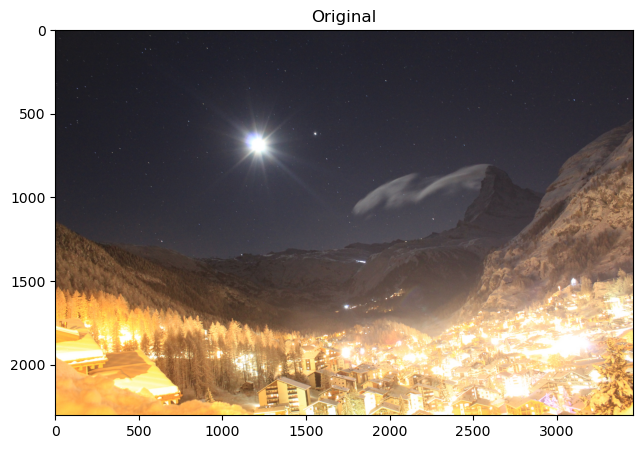

In [46]:
img_original = plt.imread("./img.jpg")
plot_image(img_original, "Original")

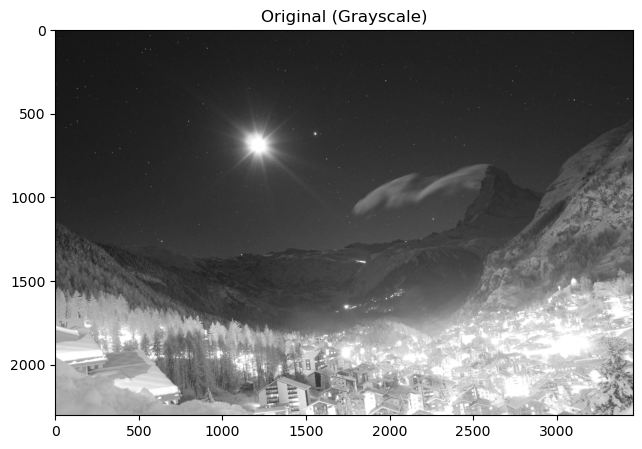

In [47]:
# Making the image greyscale.
# https://stackoverflow.com/a/9827229
img = np.mean(img_original, axis=2)
plot_image(img, "Original (Grayscale)", cmap="gray")

### (a) - Bildspektrum
>Plotten Sie die 2D-Verteilung der absoluten Werte der Fourier-Komponenten, sodass die kleinsten $k$-Werte in der Mitte liegen. Erklären Sie die Natur der Verteilung.

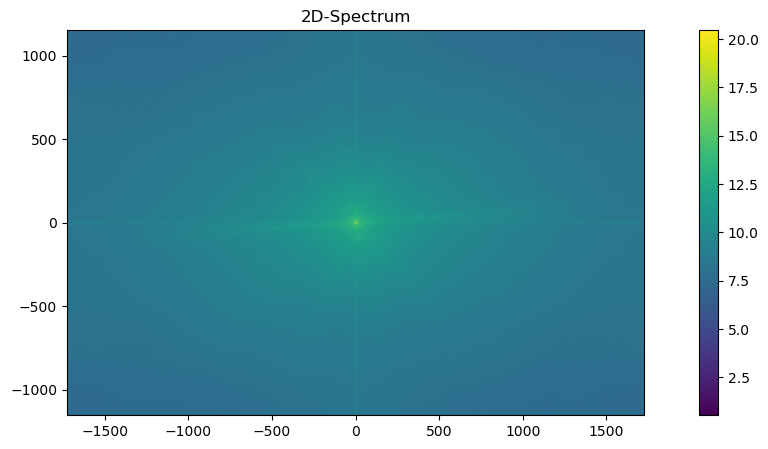

In [48]:
plot_spectrum(fftshift(fft2(img)), "2D-Spectrum")

Die 2D-Verteilung der Fourier-Komponenten zeigt die verschiedenen Frequenzen, die im Bild vorhanden sind. In der Mitte des Plots befinden sich die niedrigen Frequenzen, die für glatte Übergänge und grosse, zusammenhängende Bereiche im Bild verantwortlich sind. Die hohen Frequenzen, die feine Details und Kanten repräsentieren, liegen an den Rändern des Plots. 

Die Farben im Plot zeigen die Amplitude oder Stärke jeder Frequenz an. Helle Farben deuten auf hohe Magnituden hin, was bedeutet, dass diese Frequenzen einen grossen Beitrag zur Bildinformation leisten. Dunkle Farben weisen auf niedrige Magnituden hin, was darauf hindeutet, dass diese Frequenzen einen geringeren Beitrag zur Bildinformation leisten. 

Insgesamt zeigt der Plot, dass die meisten Informationen in natürlichen Bildern in den niedrigen Frequenzen konzentriert sind, während die hohen Frequenzen weniger Energie enthalten.

**Anmerkung**: Für diese Darstellung die absoluten Fourier Komponenten logarithmiert wurden, um den kontrast der Darstellung zu verbessern. Dabei wurde $ln(1 + abs(val))$ verwendet.

Referenz:
- [Why are the magnitudes of the fourier spectrum of an image very low?](https://www.perplexity.ai/search/7bae3a4c-96d4-4061-9833-289be445fd02?s=c)
- [Understanding Magnitude Spectrum of Images](https://dsp.stackexchange.com/questions/48373/understanding-magnitude-spectrum-of-images)


### (b) - Filter mit verschiedenen Schwellenwerten
> Entfernen Sie je die Fourier-Komponenten mit absoluter Amplitude unter dem Schwellenwert 0.001%, 0.01%, 0.1%, 1% und 10% der maximalen Amplitude. Führen Sie eine inverse Fourier-Transformation durch und stellen Sie die gefilterten Fourierkomponenten sowie die resultierenden Bilder dar. Beschreiben und erklären Sie die Unterschiede.

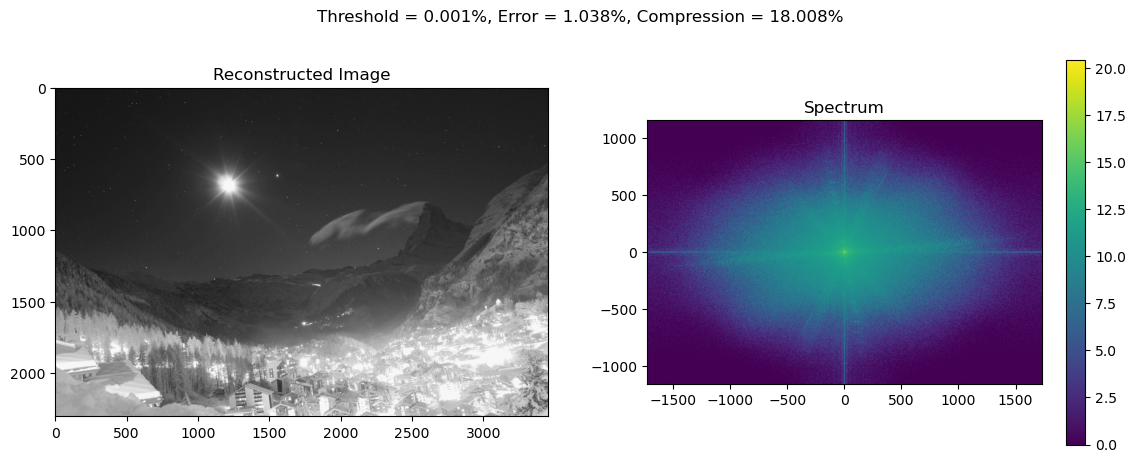

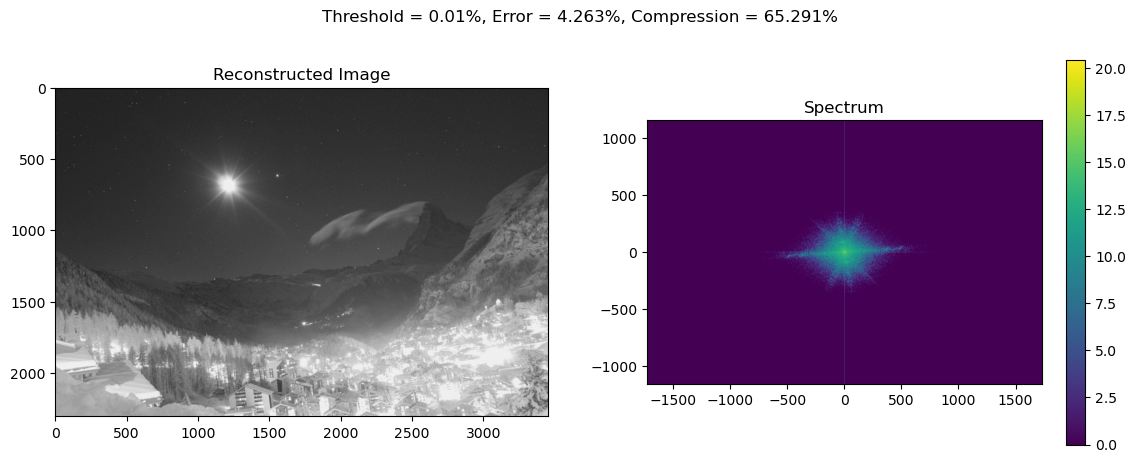

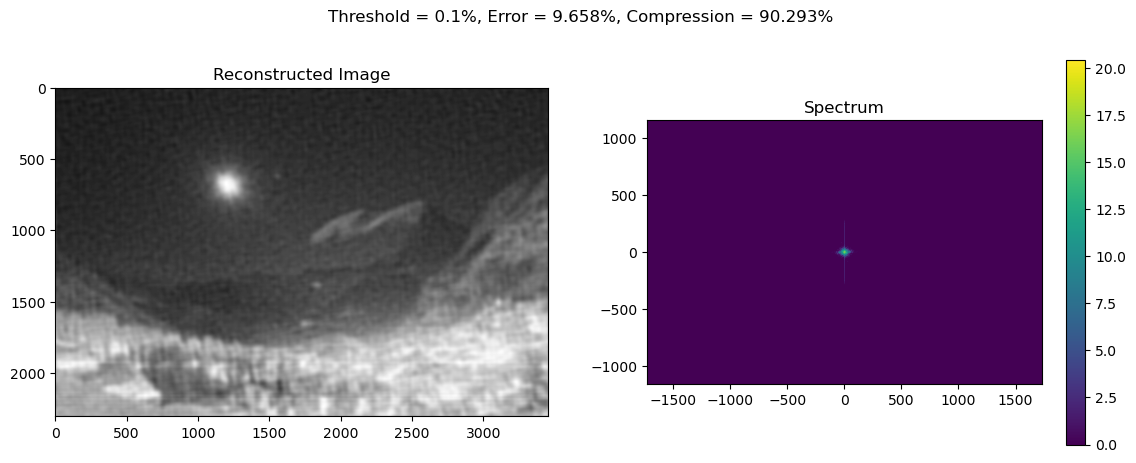

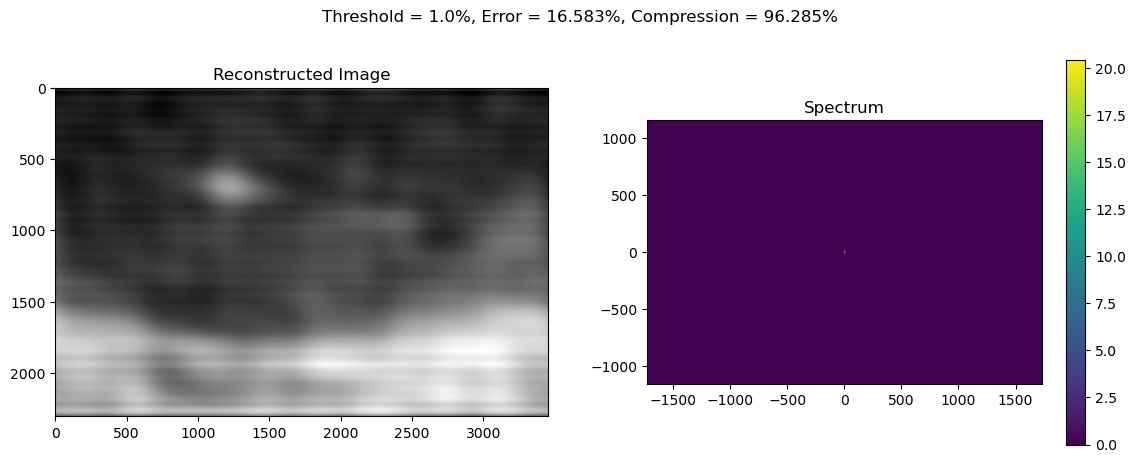

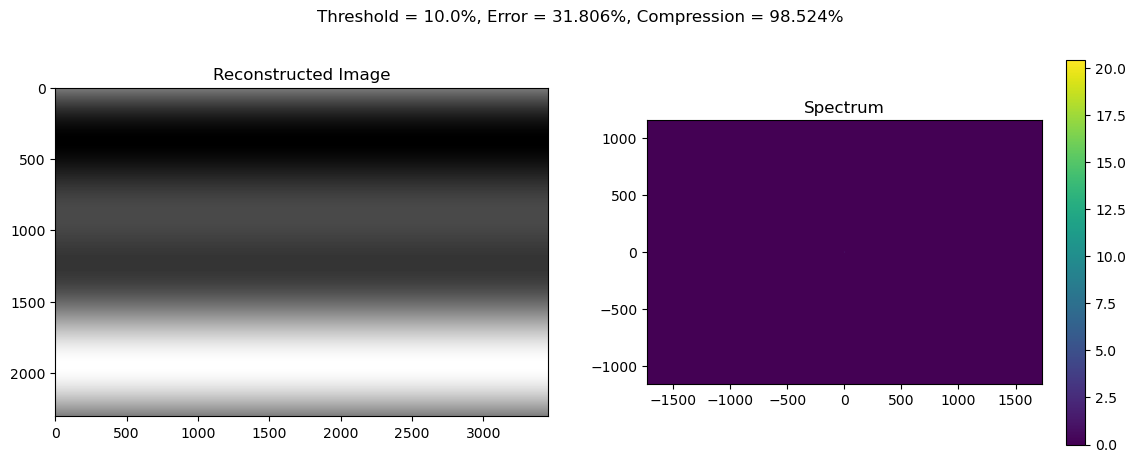

In [49]:
for threshold in [.00001, .0001, .001, .01, .1]:
    img_reconstructed, filtered_spectrum, error, compression_ratio = compress_and_reconstruct(
        img, threshold
    )

    plot_image_and_spectrum(
        img_reconstructed,
        filtered_spectrum,
        f"Threshold = {threshold*100}%, Error = {error*100:.3f}%, Compression = {compression_ratio*100:.3f}%",
    )

Je höher der Schwellenwert für die gefilterten Fourierkomponenten ist, desto mehr Komponenten werden aus dem Spektrum entfernt. Das bedeutet, dass weniger Frequenzen im rekonstruierten Bild enthalten sind, was zu einer Verringerung der Bildqualität führt. Mit einem höheren Schwellenwert werden mehr hohe Frequenzen entfernt, die für die feinen Details und Kanten im Bild verantwortlich sind. Daher wird das Bild mit zunehmendem Schwellenwert immer verschwommener und verliert mehr Details.

Der Schwellenwert ist ein Grenzwert, der dazu dient, Fourier-Komponenten auf der Grundlage ihrer Amplitude auszuwählen. Fourier-Komponenten mit einer Amplitude unterhalb des Schwellenwertes werden aus dem Spektrum entfernt, während Komponenten mit einer Amplitude oberhalb des Schwellenwertes beibehalten werden. Durch die Auswahl eines Schwellenwertes kann die Menge an Informationen, die im Bild gespeichert werden, reduziert werden, wodurch das Bild komprimiert wird. Je höher der Schwellenwert, desto stärker wird das Bild komprimiert.

### (c) - Fehlerberechnung
> Berechnen Sie den Fehler (`Aufgabe 1`) zwischen rekonstruiertem und Originalbild. Wie weit können die Daten kompressiert werden, ohne einen Fehler von höchstens $1$% zu überschreiten?

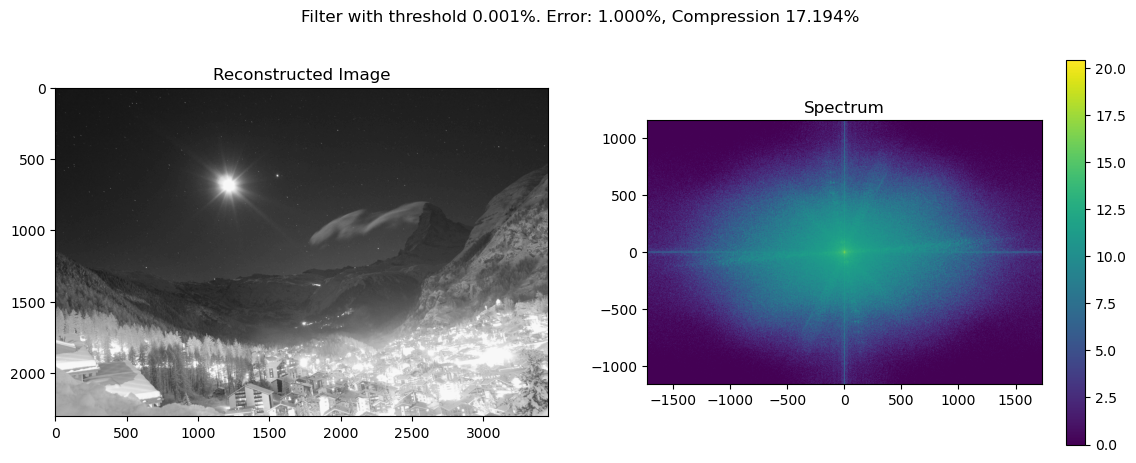

Maximum compression without exceeding 1% relative error is 17.1939%. Threshold 0.0009635696187615395%, Error: 0.9999977920576055%


In [50]:
low_threshold, high_threshold = 0, 1

# Binary search
while high_threshold - low_threshold > 1e-10:  # precision of the threshold
    mid_threshold = (low_threshold + high_threshold) / 2
    _, _, error, compression_ratio = compress_and_reconstruct(img, mid_threshold)
    
    if error <= 0.01:  # if error is acceptable, go higher
        low_threshold = mid_threshold
        max_compression = compression_ratio
    else:  # if error is too high, go lower
        high_threshold = mid_threshold

img_reconstructed, filtered_spectrum, error, data_kept = compress_and_reconstruct(
    img, low_threshold
)

plot_image_and_spectrum(
    img_reconstructed,
    filtered_spectrum,
    f"Filter with threshold {low_threshold*100:.3f}%. Error: {error*100:.3f}%, Compression {max_compression*100:.3f}%",
)

print(f"Maximum compression without exceeding 1% relative error is {max_compression*100:.4f}%. Threshold {low_threshold*100}%, Error: {error*100}%")


Der Relative Error eignet sich schlecht für die Bewertung von Bildkomprimierungen, da der Kontext von Bildstrukturen nicht beachtet wird. Vielmehr würde sich beispielsweise eine Metrik wie der [Structural Similarity Index Measure](https://www.wikiwand.com/en/Structural_similarity) eignen.

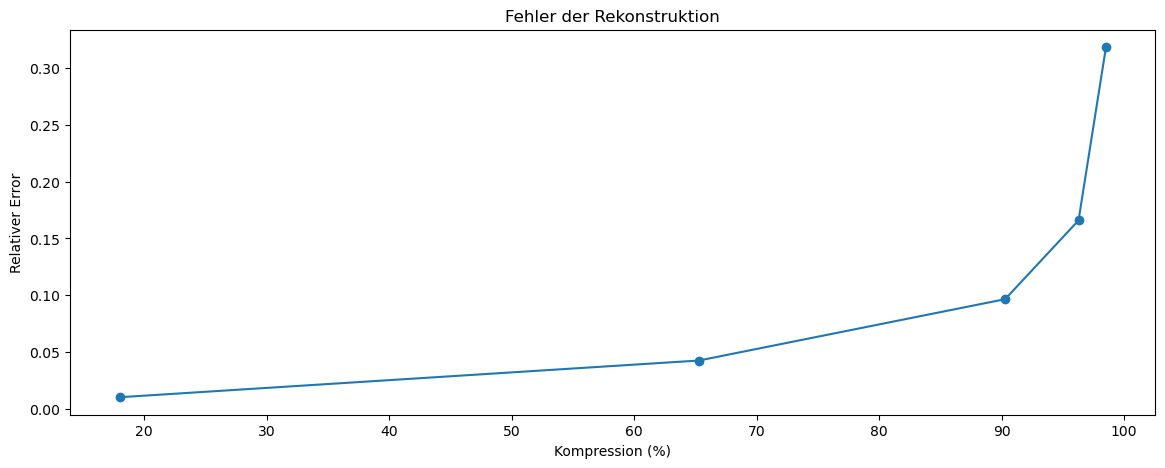

In [51]:
thresholds = [.00001, .0001, .001, .01, .1]
errors = []

compressions = []
for threshold in thresholds:
    img_reconstructed, _, error, data_kept = compress_and_reconstruct(img, threshold)
    compressions.append(data_kept)
    errors.append(error)

plt.plot(np.array(compressions) * 100, errors, marker='o')
plt.xlabel("Kompression (%)")
plt.ylabel("Relativer Error")
plt.title("Fehler der Rekonstruktion")
plt.show()

## Zusammenfassung

In unserem Projekt nutzten wir die Fourier-Analyse, um unterschiedliche Datentypen zu untersuchen und zu manipulieren. Bei der Fourier-Approximation stellten wir fest, dass Symmetrie und Glattheit von Funktionen, exemplarisch gezeigt an der hyperbolischen Kosinusfunktion, eine präzise Approximation ermöglichen. Im Gegensatz dazu ergaben exponentiell wachsende und nicht periodische Funktionen, wie die einfache und absolute Exponentialfunktion, höhere Fehler. Dieses Phänomen, bekannt als Gibbs-Phänomen, beschreibt das Auftreten von Überschwingerspitzen an den Stellen von Unstetigkeiten, wenn wir versuchen, eine Funktion mit Fourier-Reihen zu approximieren.

Durch die Fourier-Analyse der Sonnenfleckendaten konnten wir dominante periodische Muster identifizieren, die auf den 11-jährigen Sonnenzyklus hinweisen. Zudem wurden kleinere Zyklen entdeckt, deren genaue Rolle und Bedeutung jedoch weitere Untersuchungen erfordern.

Die Anwendung der Fourier-Transformation auf eine Audio-Datei offenbarte, dass Frequenzen eine entscheidende Rolle bei der Klangfarbe spielen: Tiefe Töne korrespondierten mit Frequenzen unter $2$ kHz, hohe Töne mit Frequenzen darüber. 

Unsere Analyse eines Bildes mit der Fourier-Transformation zeigte, dass hauptsächlich niedrige Frequenzen die meisten Informationen tragen, während hohe Frequenzen, die für feine Details verantwortlich sind, eine geringere Amplitude aufweisen. Durch Variation des Schwellenwerts zur Kompression konnten wir bei einem sehr geringen prozentualen Anteil der maximalen Amplitude einen Rekonstruktionsfehler von unter $1$% erreichen.

Abschliessend bietet die Fourier-Analyse tiefe Einblicke in die Struktur und Eigenschaften verschiedener Datentypen und ermöglicht praktische Anwendungen wie Signal- und Bildkompression. Gleichwohl stiessen wir auf Grenzen dieser Methode und sahen die Notwendigkeit für weitere Werkzeuge, wie den Strukturähnlichkeitsindex (SSIM), der die wahrgenommene Qualität eines komprimierten Bildes besser bewertet, indem er den Kontext von Bildstrukturen und die räumliche Verteilung der Fehler berücksichtigt.

## Lerntagebuch